# Data Preparation Woodland Way
### _FYP: Continuous Condition Assessment of Automatic Control Valves_
#### _Imperial College London_
#### _Department of Civil & Environmental Engineering_
#### _Megat Riza Makhzan_

Last modified: 20th March 2025

This notebook contains the data imputation code for $P_{in}$, $P_{out}$, $flow$, and $P_{target}$. A full timeseries of $P_{res}$ is generated by calculating the difference between $P_{target}$ and $P_{out}$. The complete timeseries are exported to an xlsx file at the end of the code. 

## Setup

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from datetime import datetime
import time
import glob
import os
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.stats import linregress
import calendar


# suppress unnecessary warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [14]:
print(pd. __version__)           # 1.4.0
print(matplotlib. __version__)   # 3.5.0
print(np. __version__)           # 1.22.0
print(sns. __version__)          # 0.11.2

1.4.0
3.5.0
1.22.4
0.11.2


In [15]:
%matplotlib inline

# plt settings
plot_size   = 30
plot_width  = 60
plot_height = 30

params = {'legend.fontsize': plot_width,
          'figure.figsize': (plot_width,plot_height),
          'axes.labelsize': plot_width,
          'axes.titlesize': plot_width*1.5,
          'xtick.labelsize': plot_width,
          'ytick.labelsize': plot_width,
          'axes.titlepad': plot_width,
          'font.size': plot_width,
          'font.family': 'sans-serif',  
          'font.sans-serif': 'Arial',
          'axes.linewidth':    2,
          'grid.linewidth': 2}
plt.rcParams.update(params)

## 1. Load Data

In [16]:
Pout_str = 'pressure_out'
Pin_str = 'pressure_in'
Pc_str = 'pressure_chamber'
Ptarget_str = 'pressure_target'
Pres_str = 'residual_pressure'
Flow_str = 'flow'
Stem_str = 'valve_position'

In [17]:
path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Pout\Control Profile'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
P_target = pd.concat(df_from_each_file, ignore_index = True)

path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Pout\Claval'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
P_out_claval = pd.concat(df_from_each_file, ignore_index = True)

path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Pout\tsrt'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
P_out_infras = pd.concat(df_from_each_file, ignore_index = True)

In [18]:
path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Pin\Claval'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
P_in_claval = pd.concat(df_from_each_file, ignore_index = True)

path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Pin\tsrt'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
P_in_infras = pd.concat(df_from_each_file, ignore_index = True)


In [19]:
path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Flow\Claval'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
Flow_claval = pd.concat(df_from_each_file, ignore_index = True)

path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Flow\tsrt'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
Flow_infras = pd.concat(df_from_each_file, ignore_index = True)


In [20]:
path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Pc\Claval'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
P_c_claval = pd.concat(df_from_each_file, ignore_index = True)

path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\Pc\Inflowsense'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
P_c_inflows = pd.concat(df_from_each_file, ignore_index = True)
P_c_inflows.rename(columns={'pressure': 'pressure_chamber'}, inplace=True)

In [21]:
path = r'C:\Users\megat\Desktop\MegatAiman\University\Year4\FYP\Data\WoodlandWay\StemPos'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
Stem_claval = pd.concat(df_from_each_file, ignore_index = True)

In [22]:
Claval_time = pd.to_datetime(P_target['time'], unit='s')
Claval_time = Claval_time.dt.floor('T')
Infras_time = pd.to_datetime(P_out_infras['time'], unit = 's')
Inflows_time = pd.to_datetime(P_c_inflows['time'], unit = 's')

In [23]:
P_out_claval = pd.concat([Claval_time, P_out_claval[Pout_str]], axis = 1).set_index('time')
P_out_infras = pd.concat([Infras_time, P_out_infras[Pout_str]], axis = 1).set_index('time')

P_in_claval = pd.concat([Claval_time, P_in_claval[Pin_str]], axis = 1).set_index('time')
P_in_infras = pd.concat([Infras_time, P_in_infras[Pin_str]], axis = 1).set_index('time')

Flow_claval = pd.concat([Claval_time, Flow_claval[Flow_str]], axis = 1).set_index('time')
Flow_infras = pd.concat([Infras_time, Flow_infras[Flow_str]], axis = 1).set_index('time')

P_c_claval = pd.concat([Claval_time, P_c_claval[Pc_str]], axis = 1).set_index('time')
P_c_inflows = pd.concat([Inflows_time, P_c_inflows[Pc_str]], axis = 1).set_index('time')

Stem_claval = pd.concat([Claval_time, Stem_claval[Stem_str]], axis = 1).set_index('time')
P_target = pd.concat([Claval_time, P_target[Ptarget_str]], axis = 1).set_index('time')

## 2. Raw data plots

The following code blocks plot the valve timeseries datasets for the

1) Cla-Val dataset

2) InfraSense dataset

3) Cla-Val vs InfraSense outlet pressure comparison

4) Cla-Val vs InfraSense flow comparison

Figures 1) & 2) include inlet pressure, outlet pressure, & flow. Plots of target pressure, cover chamber pressure, and stem position can be uncommented for info. Start & end dates can also be adjusted for further inspection.

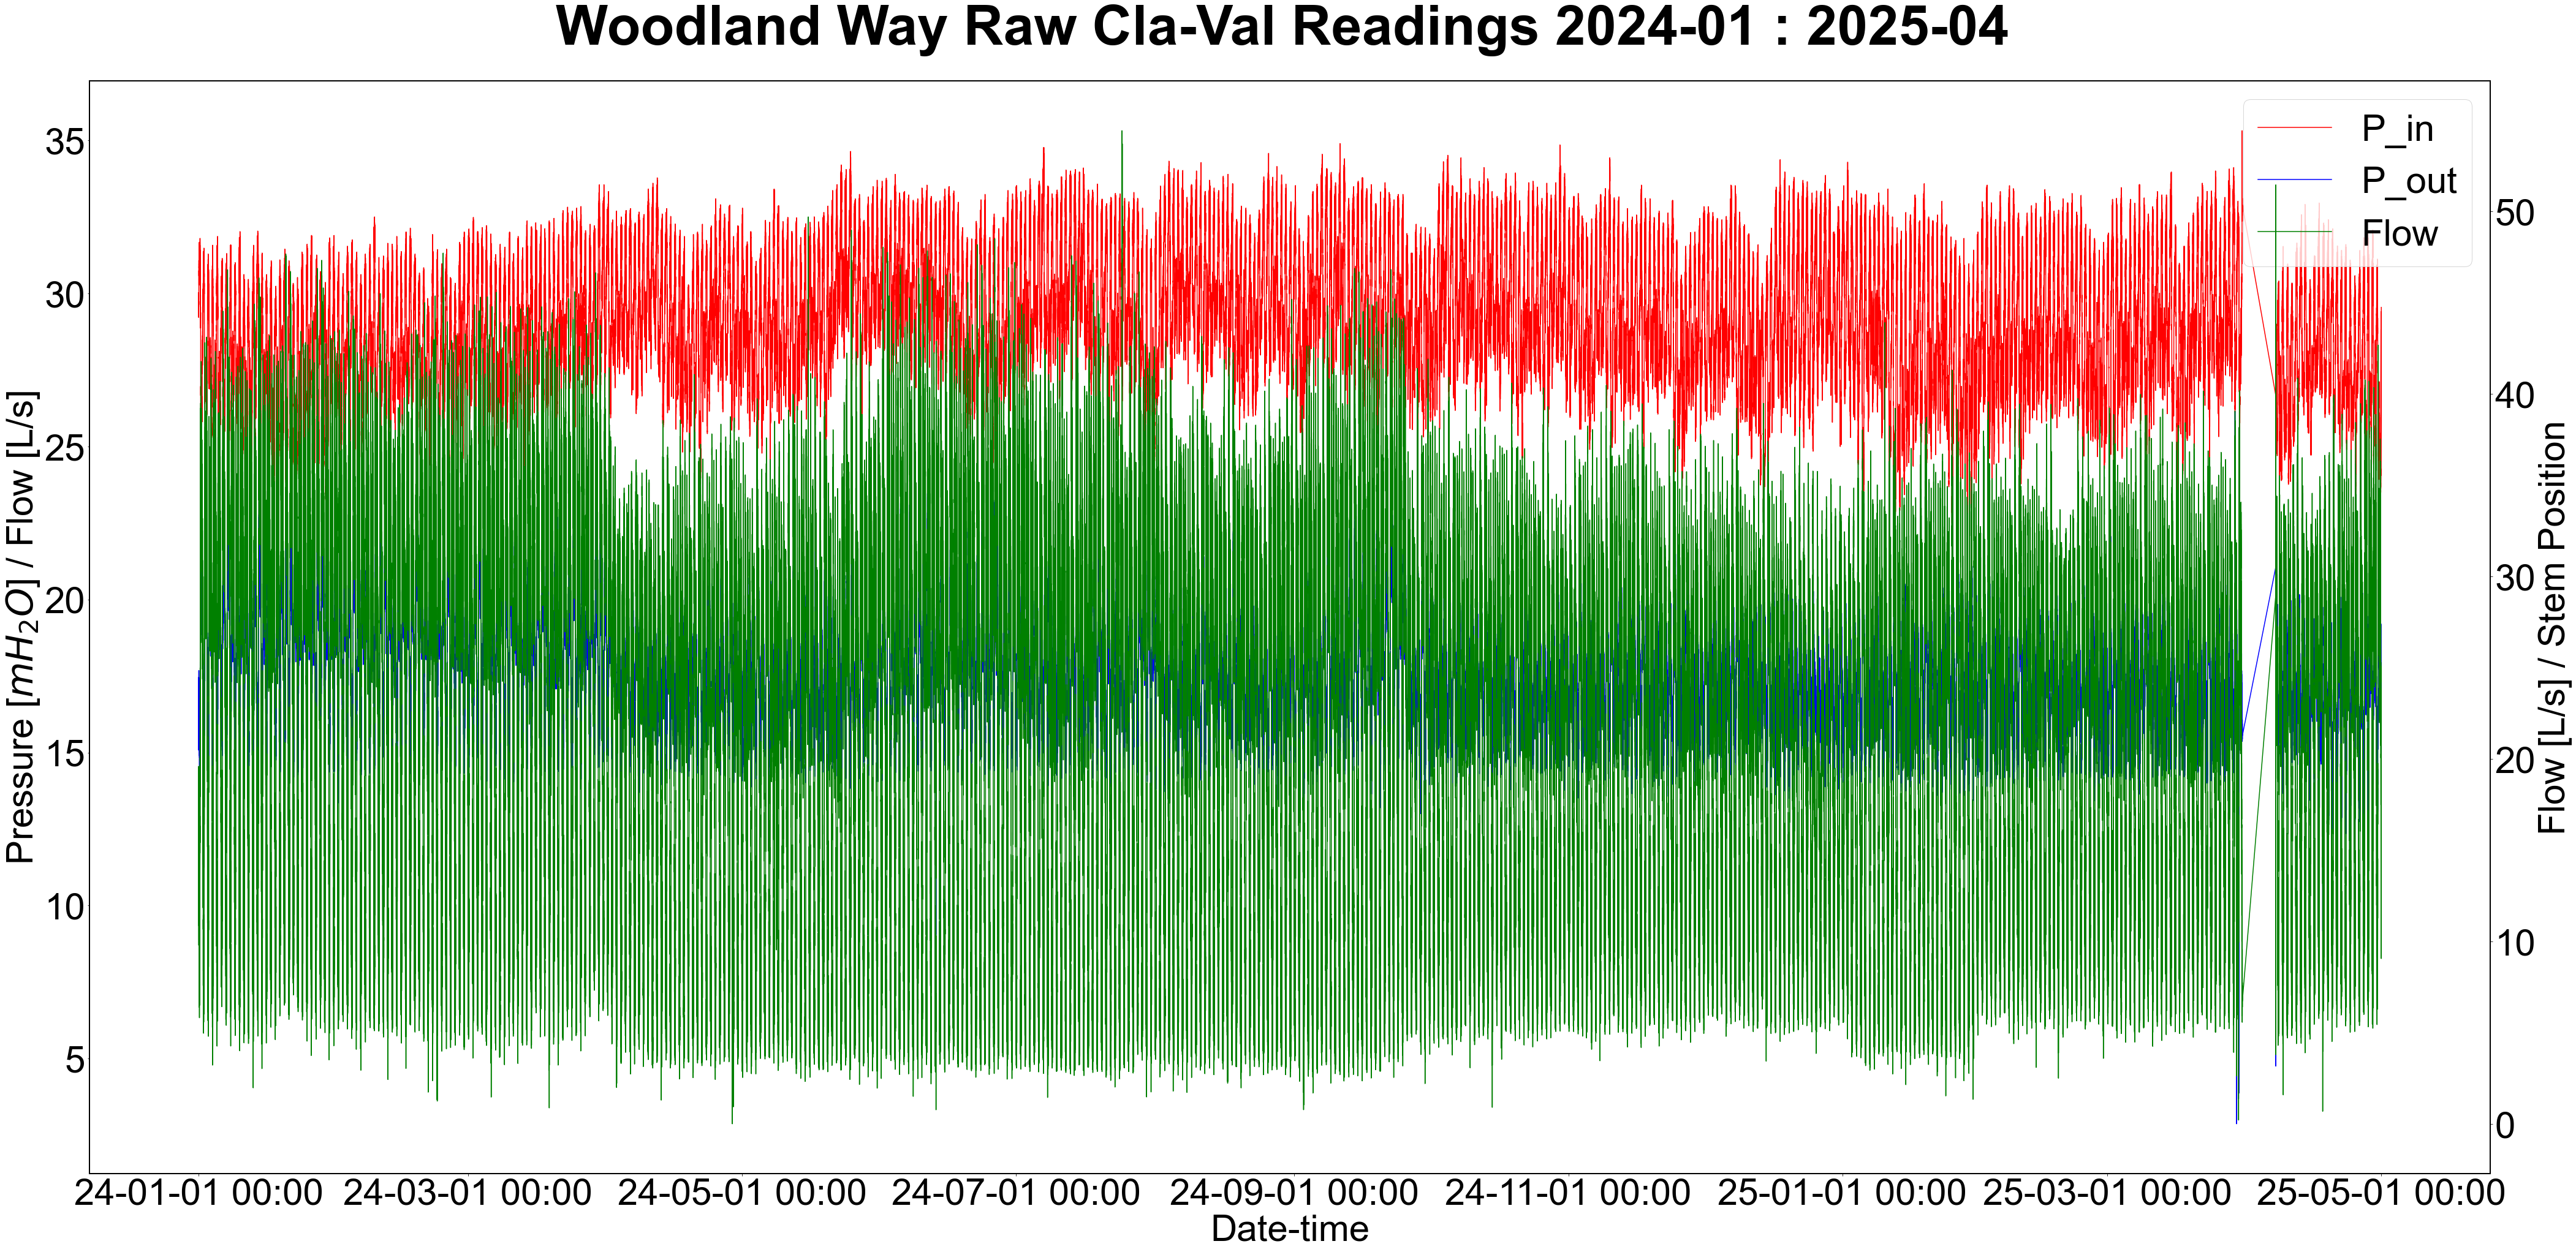

In [24]:
start = '2024-01'
end = '2025-04'


fig, ax1 = plt.subplots()

ax1.plot(P_in_claval[start:end], label='P_in', color='red')
ax1.plot(P_out_claval[start:end], label='P_out', color='blue')
#ax1.plot(P_target[start:end], label='P_target', color='cyan')
#ax1.plot(P_c_claval[start:end], label='P_c', color='orange')
ax1.set_ylabel(r'Pressure [$mH_2O$] / Flow [L/s]')
ax1.set_xlabel('Date-time')

ax2 = ax1.twinx()
ax2.plot(Flow_claval[start:end], label='Flow', color='green')
#ax2.plot(Stem_claval[start:end], label='Stem position', color='black')
ax2.set_ylabel('Flow [L/s] / Stem Position') 

plt.title(f'Woodland Way Raw Cla-Val Readings {start} : {end} ', fontweight='bold')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M' ))

plt.tight_layout()
plt.show()

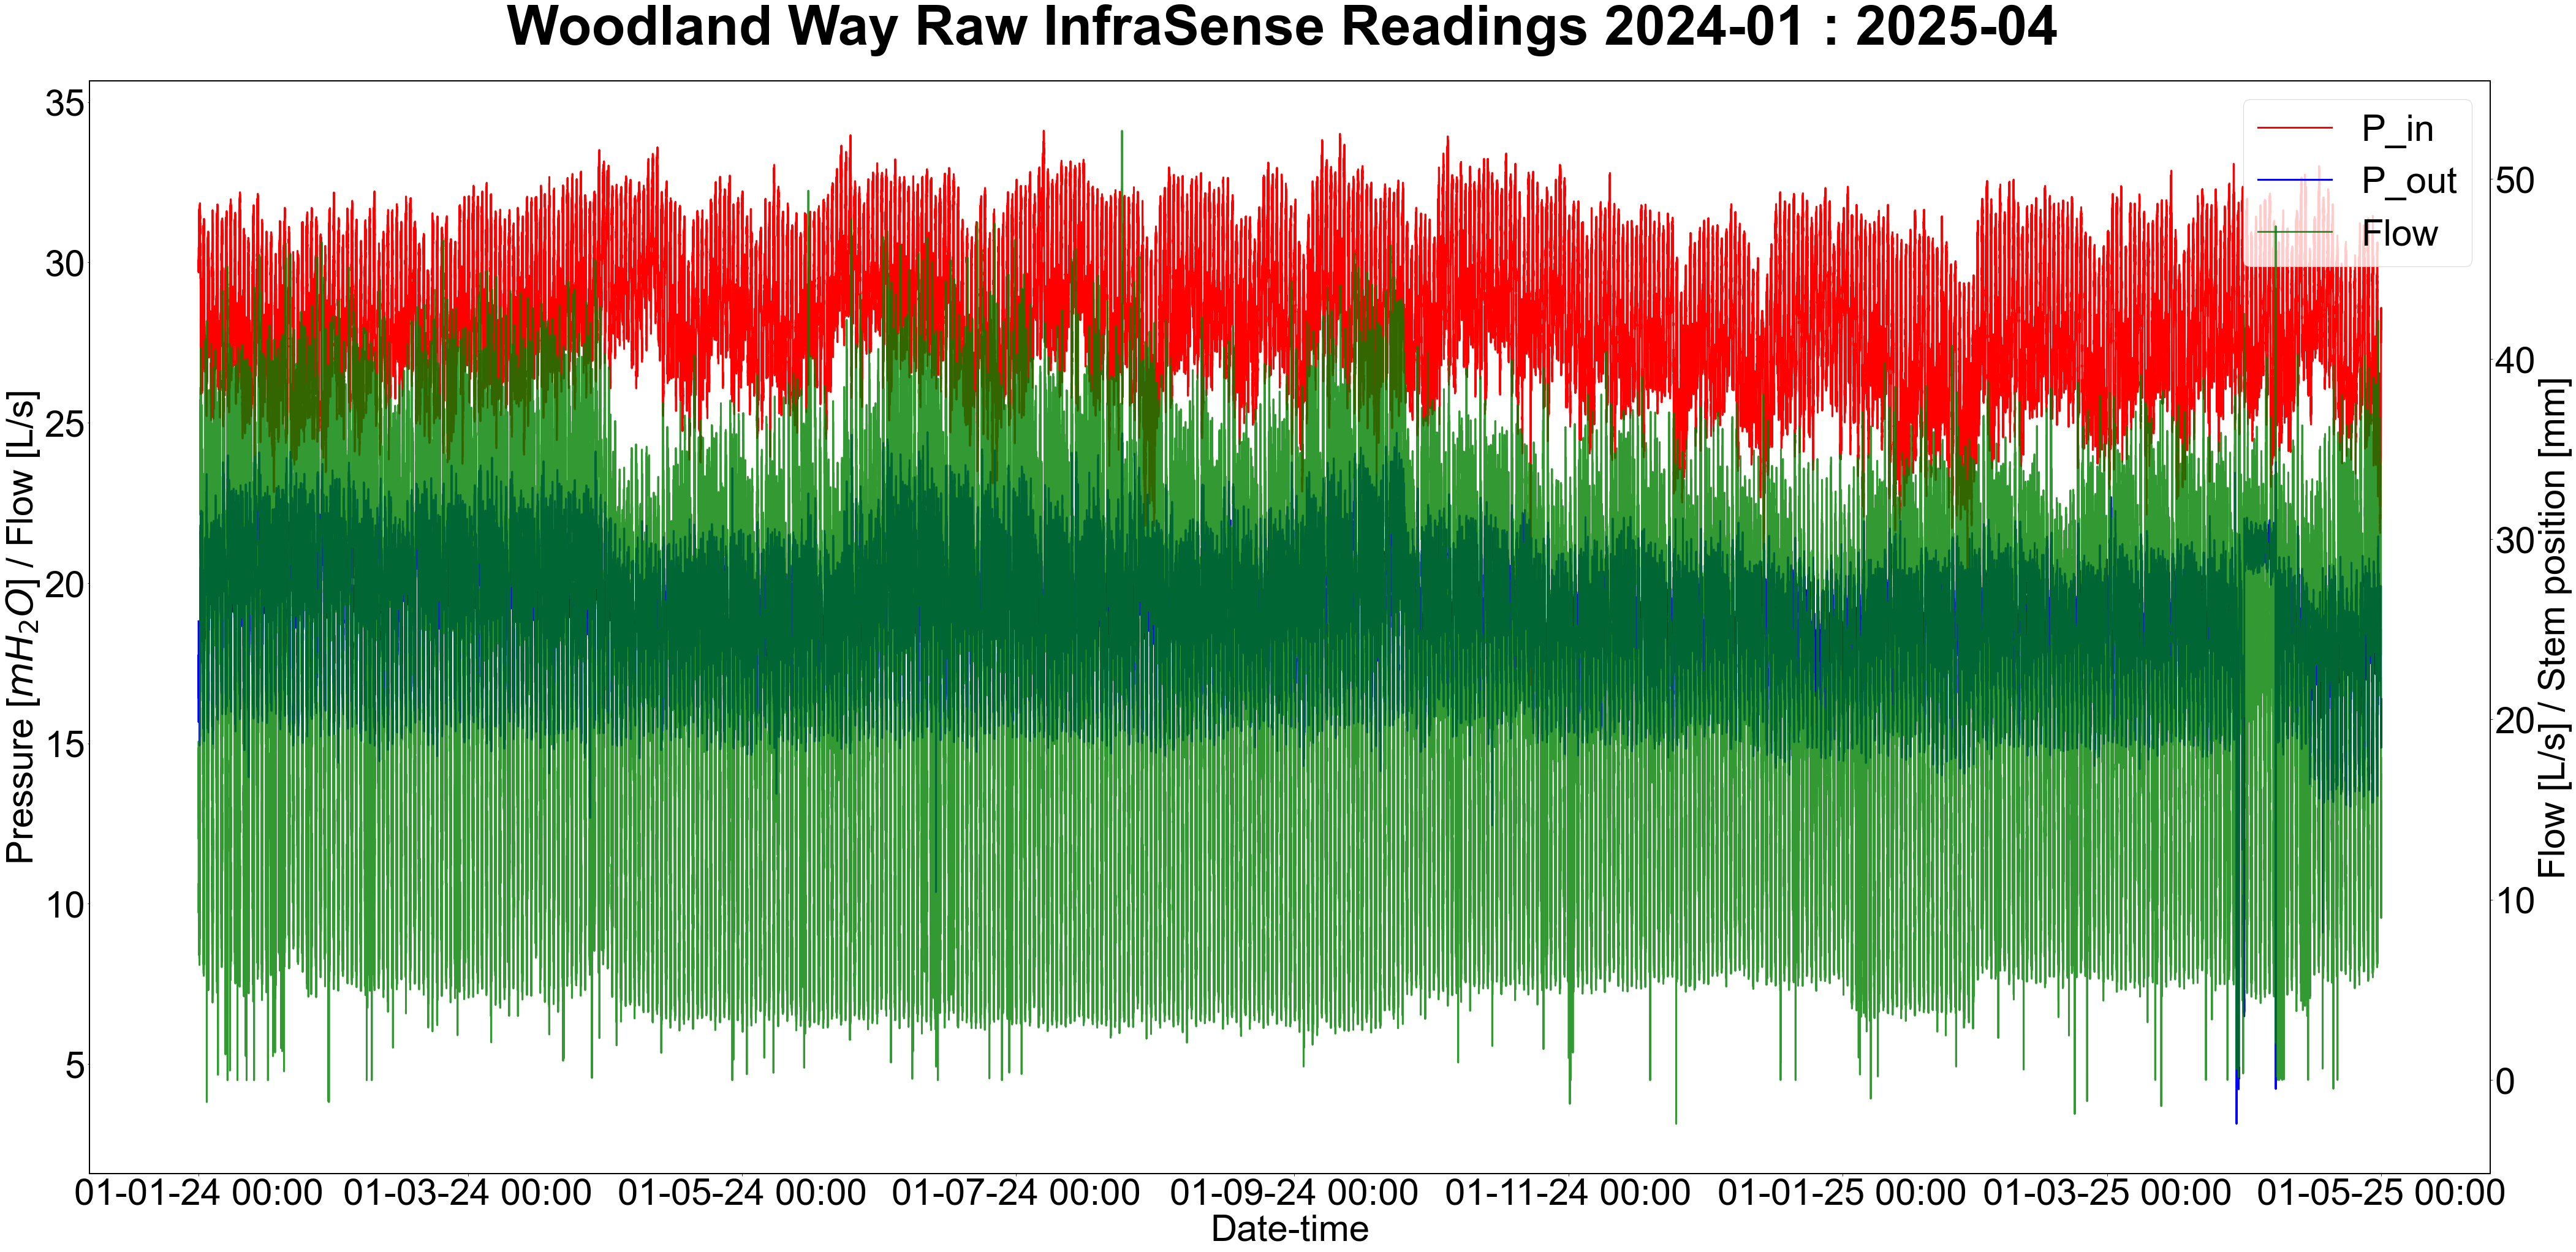

In [25]:
start = '2024-01'
end = '2025-04'

fig, ax1 = plt.subplots()

ax1.plot(P_in_infras[start:end].resample('1T').mean(), label='P_in', color='red', linewidth = 3)
ax1.plot(P_out_infras[start:end].resample('1T').mean(), label='P_out', color='blue', linewidth = 3)
#ax1.plot(P_target[start:end], label='P_target', color='cyan')
#ax1.plot(P_c_infras[start:end], label='P_c', color='orange')
ax1.set_ylabel(r'Pressure [$mH_2O$] / Flow [L/s]')
ax1.set_xlabel('Date-time')

ax2 = ax1.twinx()
ax2.plot(Flow_infras[start:end].resample('1T').mean(), label='Flow', color='green', linewidth = 3, alpha = 0.8)
#ax2.plot(Stem_claval[start:end], label='Stem position', color='black')
ax2.set_ylabel('Flow [L/s] / Stem position [mm]') 


plt.title(f'Woodland Way Raw InfraSense Readings {start} : {end} ', fontweight='bold')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M' ))

plt.tight_layout()
plt.show()

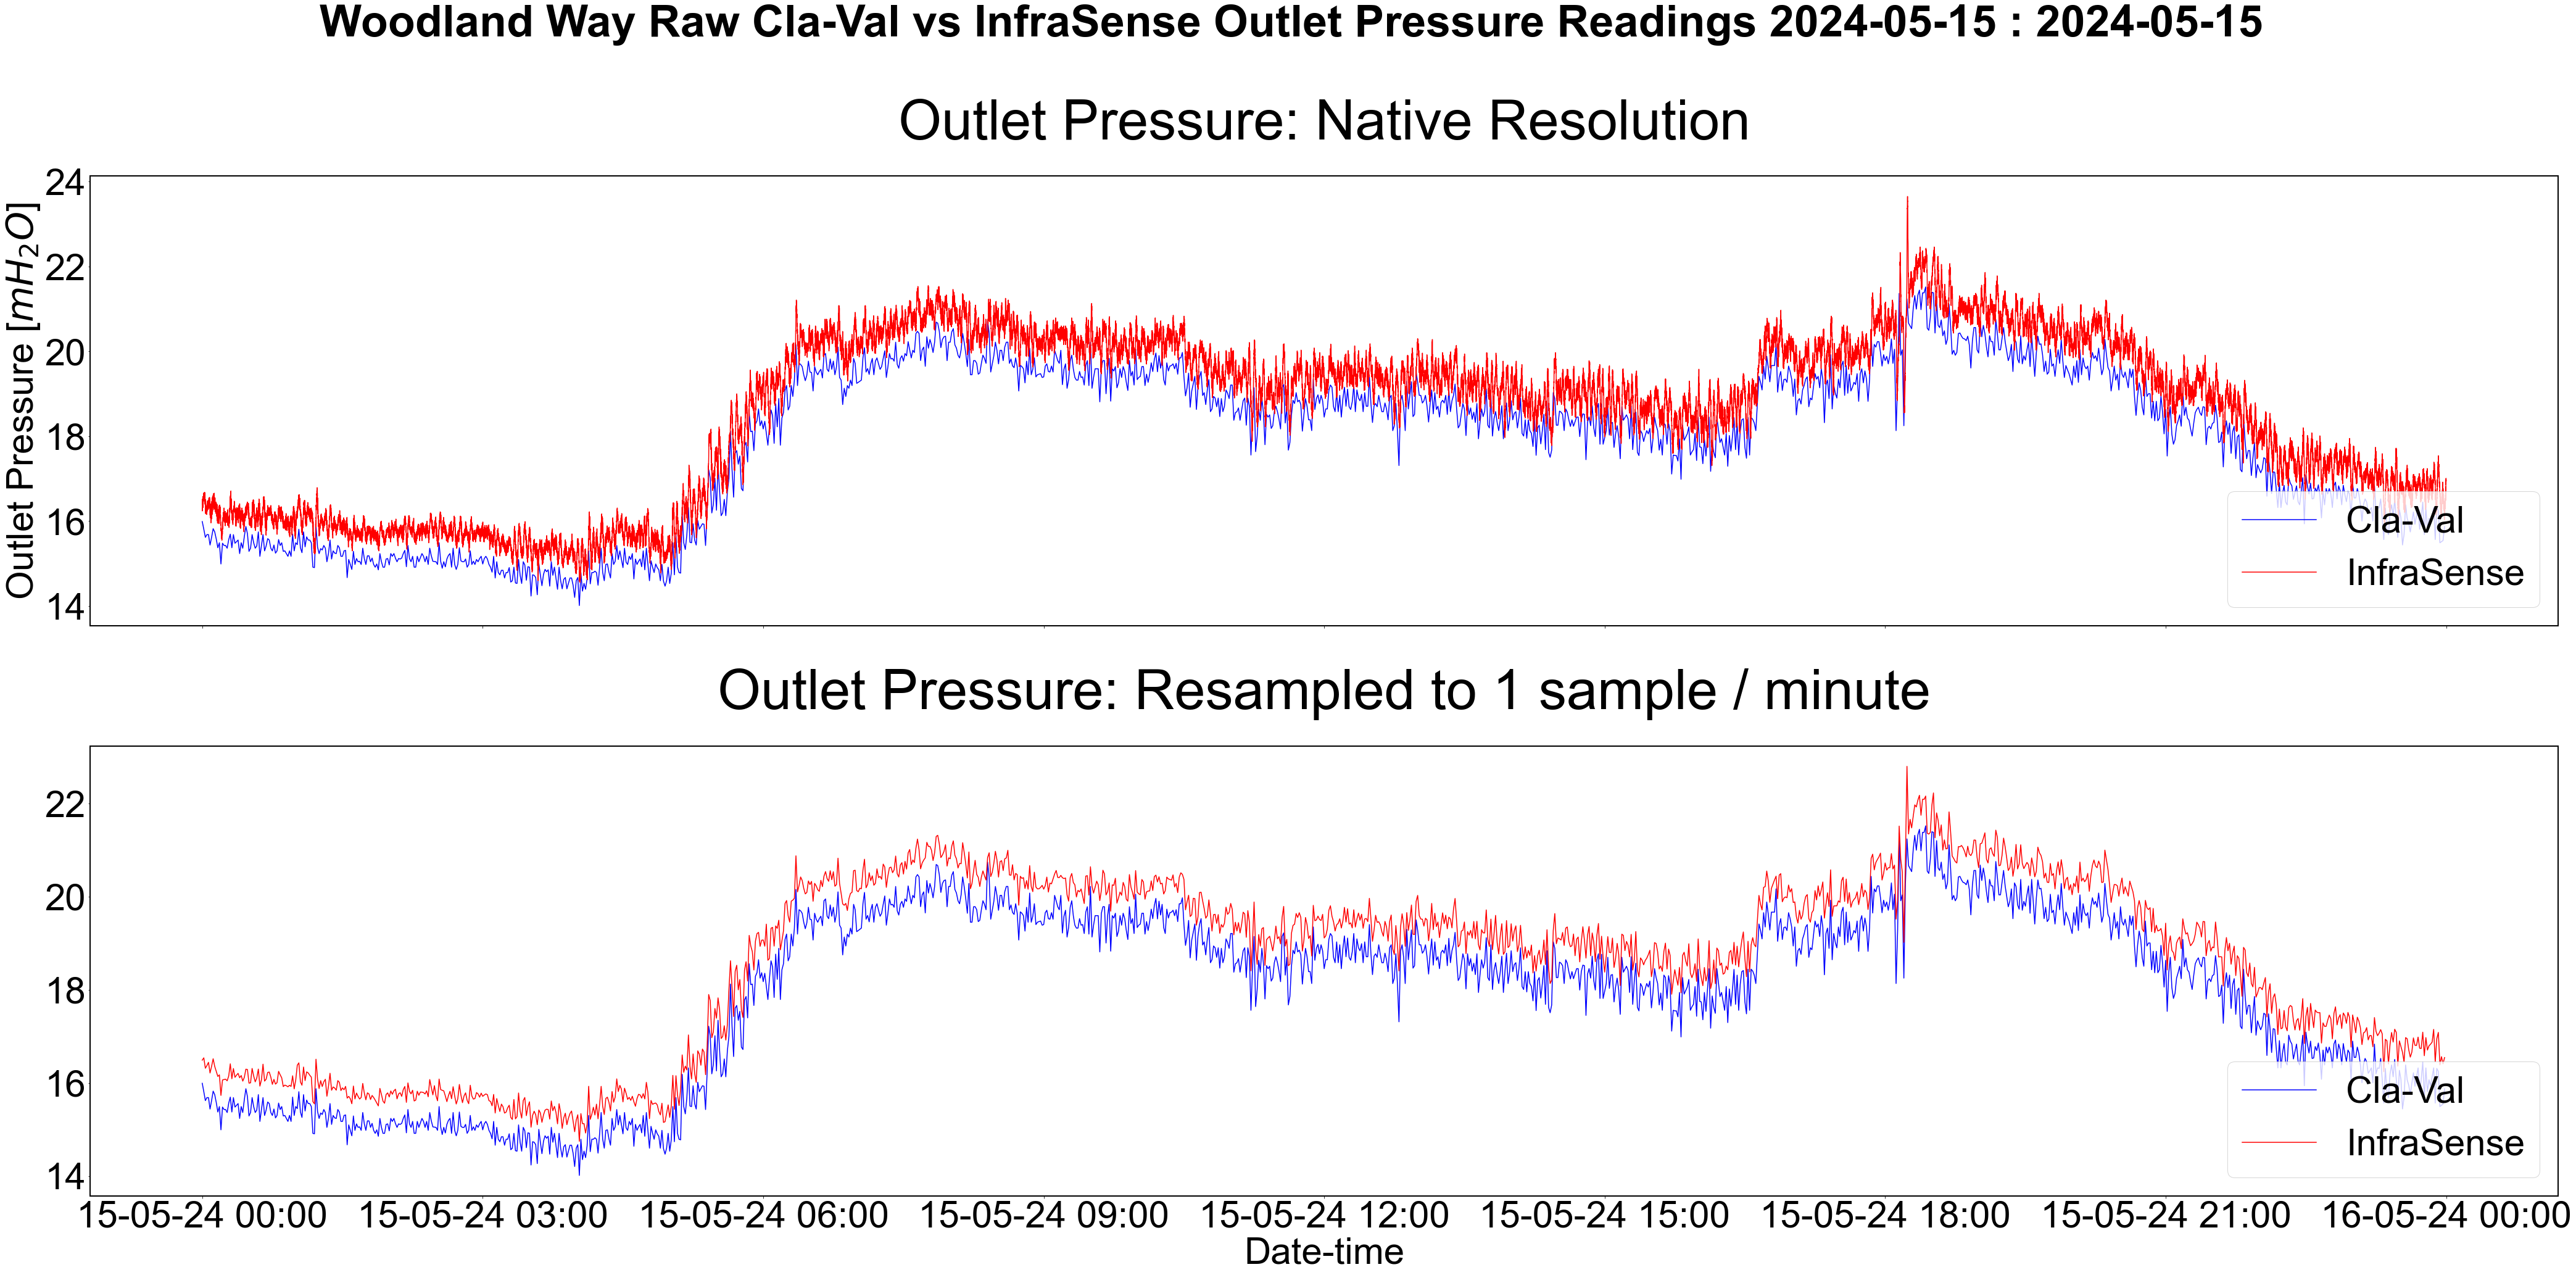

In [26]:
start = '2024-05-15'
end = '2024-05-15'

fig, ax1 = plt.subplots(2,1, sharex=True)

ax1[0].plot(P_out_claval[start:end], label='Cla-Val', color='blue')
ax1[0].plot(P_out_infras[start:end], label='InfraSense', color='red')
ax1[0].set_ylabel(r'Outlet Pressure [$mH_2O$]')
ax1[0].set_title('Outlet Pressure: Native Resolution')
ax1[0].legend(loc='lower right')

ax1[1].plot(P_out_claval[start:end], label='Cla-Val', color='blue')
ax1[1].plot(P_out_infras[start:end].resample('1T').mean(), label='InfraSense', color='red')
ax1[0].set_ylabel(r'Outlet Pressure [$mH_2O$]')
ax1[1].set_xlabel('Date-time')
ax1[1].set_title('Outlet Pressure: Resampled to 1 sample / minute')
ax1[1].legend(loc='lower right')
ax1[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M' ))
plt.suptitle(f'Woodland Way Raw Cla-Val vs InfraSense Outlet Pressure Readings {start} : {end} ', fontweight='bold')
plt.tight_layout()
plt.show()

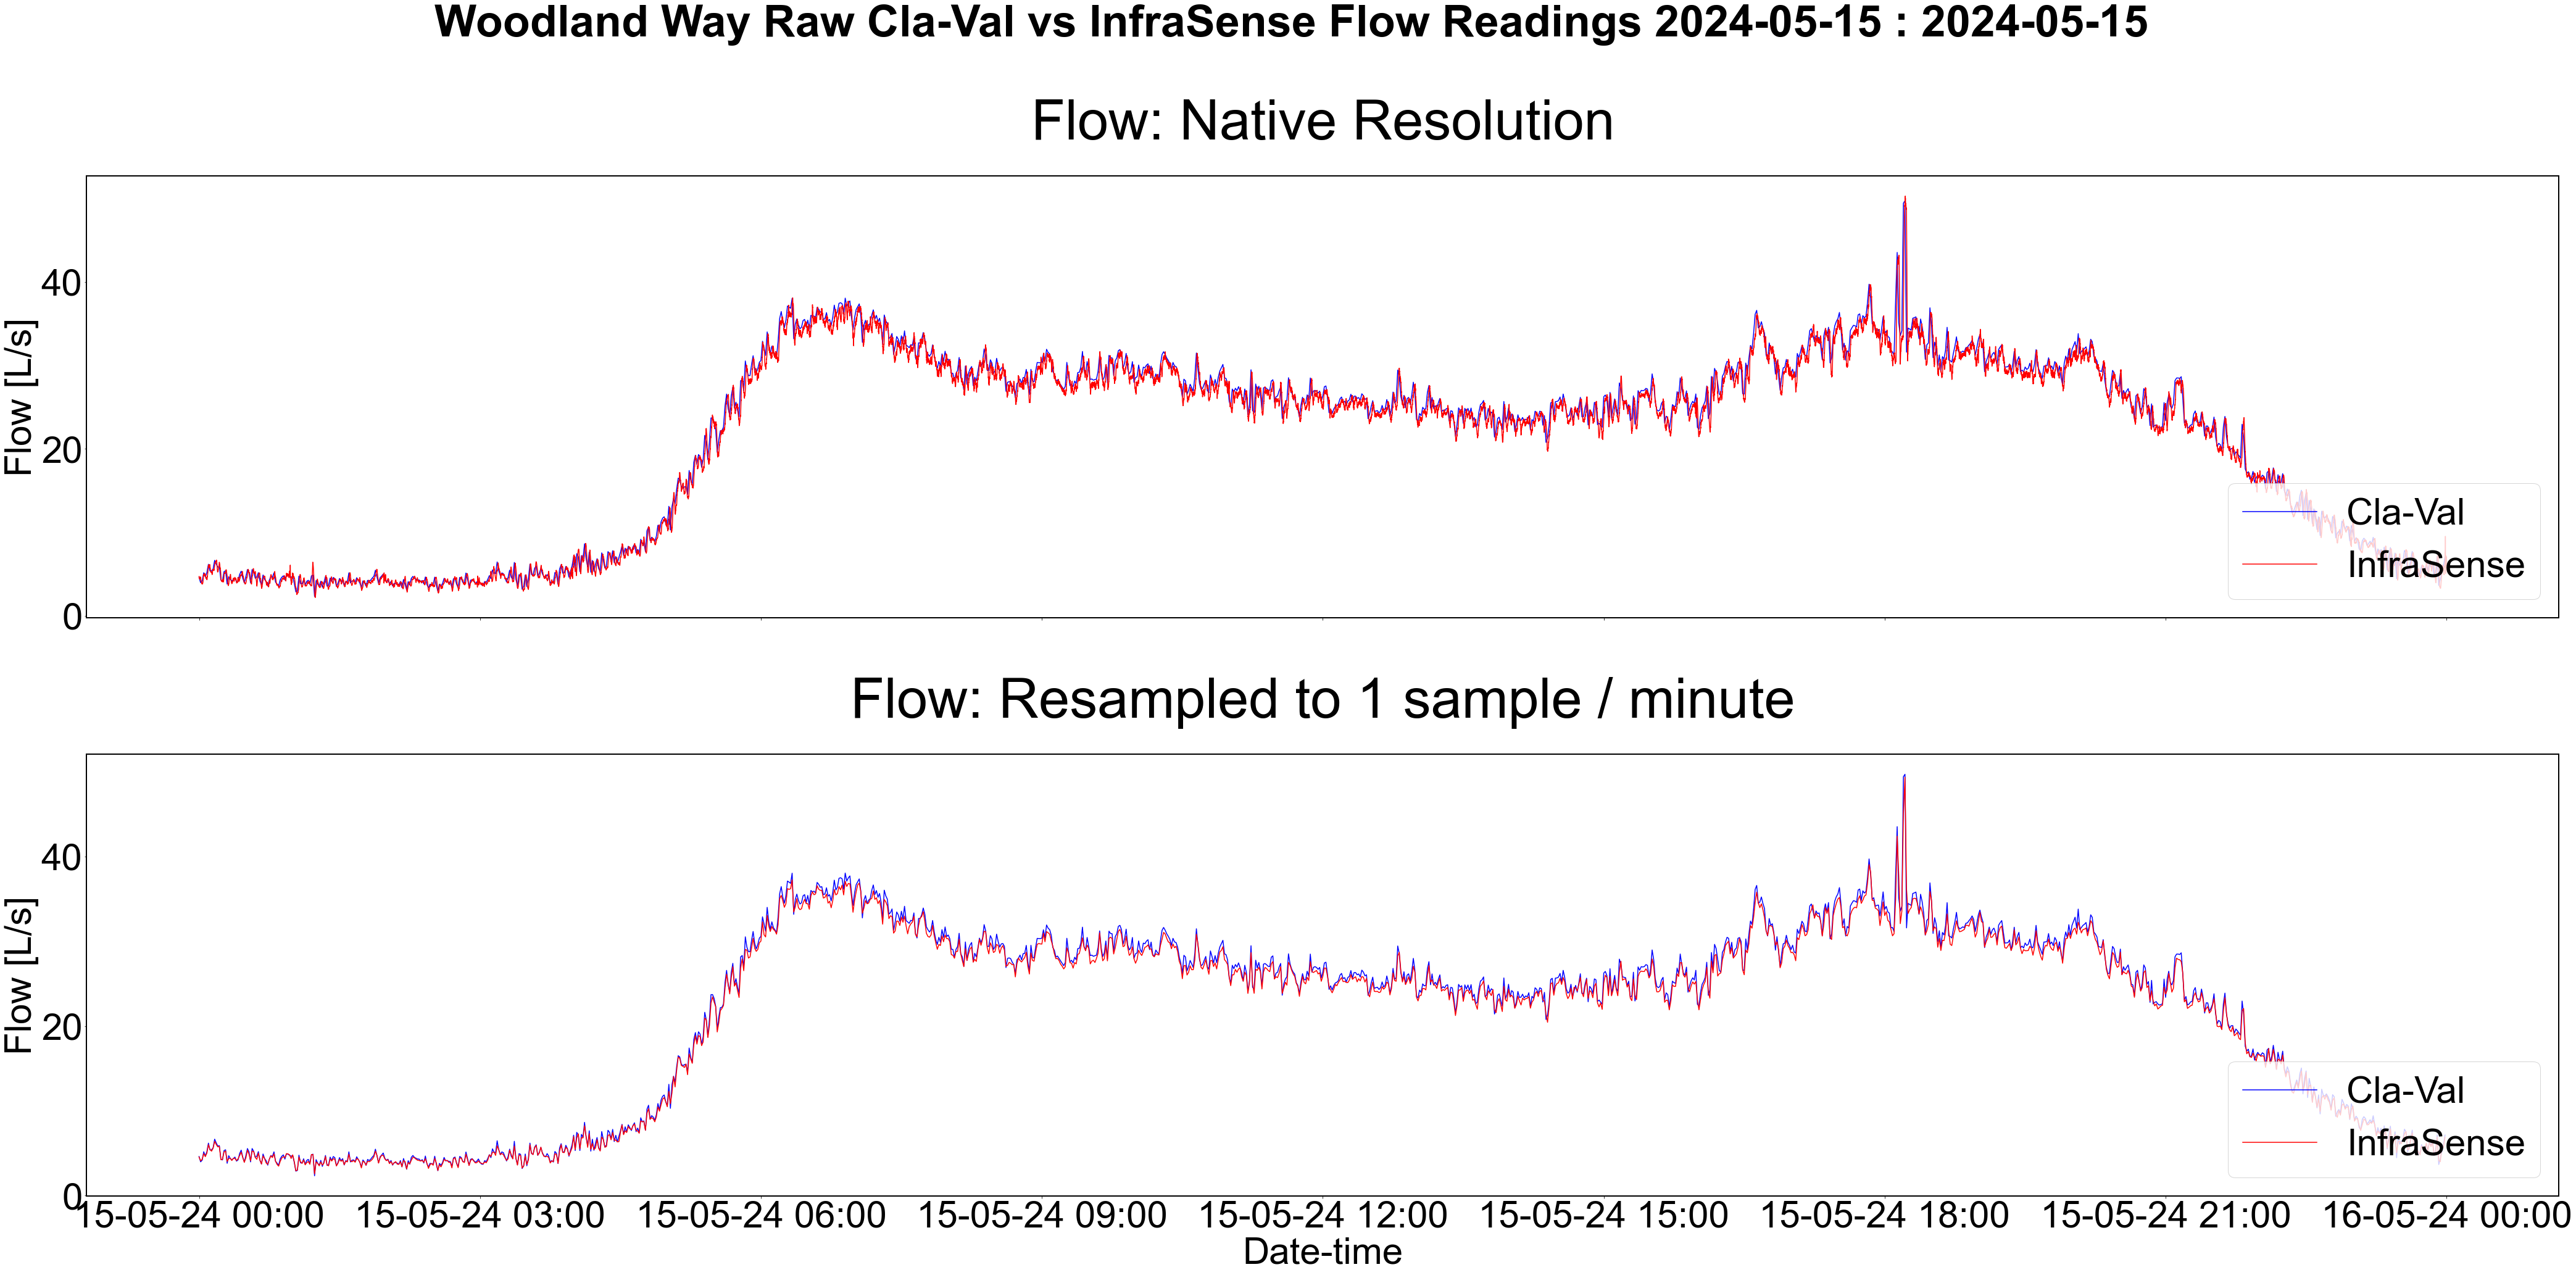

In [27]:
start = '2024-05-15'
end = '2024-05-15'

fig, ax1 = plt.subplots(2,1, sharex=True)

ax1[0].plot(Flow_claval[start:end], label='Cla-Val', color='blue')
ax1[0].plot(Flow_infras[start:end], label='InfraSense', color='red')
ax1[0].set_ylabel('Flow [L/s]')
ax1[0].set_title('Flow: Native Resolution')
ax1[0].legend(loc='lower right')

ax1[1].plot(Flow_claval[start:end], label='Cla-Val', color='blue')
ax1[1].plot(Flow_infras[start:end].resample('1T').mean(), label='InfraSense', color='red')
ax1[1].set_ylabel('Flow [L/s]')
ax1[1].set_xlabel('Date-time')
ax1[1].set_title('Flow: Resampled to 1 sample / minute')
ax1[1].legend(loc='lower right')
ax1[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M' ))
plt.suptitle(f'Woodland Way Raw Cla-Val vs InfraSense Flow Readings {start} : {end} ', fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Data imputation

The following code blocks cover the process of data imputation used for further analysis.

The section of code below identifies prolonoged data gaps from the Cla-Val and timeseries datasets.

In [28]:
def find_long_missing_periods(df, freq, min_gap_units):

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq=freq)
    df_full = df.reindex(full_idx)
    df_full = df_full.to_frame(name='value') if isinstance(df_full, pd.Series) else df_full
    df_full['missing'] = df_full.iloc[:, 0].isna().astype(int)
    df_full['run_id'] = (df_full['missing'] != df_full['missing'].shift()).cumsum()
    runs = (df_full.groupby('run_id').agg(
            start=('missing', lambda x: x.index[0]),
            end  =('missing', lambda x: x.index[-1]),
            length=('missing', 'sum')).reset_index(drop=True))
    

    long_runs = runs[runs['length'] >= min_gap_units].copy()
    long_runs['duration'] = (long_runs['end'] - long_runs['start']) + pd.Timedelta(freq)
    
    return long_runs[['start','end','length','duration']]


long_claval = find_long_missing_periods(Flow_claval, freq='1T', min_gap_units=60)
print("Cla-Val long missing periods (>1 hr):")
print(long_claval)
long_infras = find_long_missing_periods(Flow_infras, freq='1S', min_gap_units=3600)
print("\nInfraSense long missing periods (>1 hr):")
print(long_infras)

Cla-Val long missing periods (>1 hr):
                    start                 end  length        duration
14781 2025-03-31 01:25:00 2025-04-07 11:51:00   10707 7 days 10:27:00

InfraSense long missing periods (>1 hr):
                 start                 end  length        duration
1  2024-01-09 10:43:03 2024-01-09 12:22:34    5972 0 days 01:39:32
7  2024-05-16 13:43:15 2024-05-16 17:10:36   12442 0 days 03:27:22
9  2024-07-05 01:23:47 2024-07-05 03:30:32    7606 0 days 02:06:46
17 2024-10-27 17:34:00 2024-10-27 19:46:59    7980 0 days 02:13:00
19 2024-11-22 20:37:42 2024-11-22 22:24:04    6383 0 days 01:46:23
21 2025-02-09 10:49:08 2025-02-09 12:35:03    6356 0 days 01:45:56
23 2025-02-10 19:35:15 2025-02-10 21:44:04    7730 0 days 02:08:50
25 2025-02-11 09:39:46 2025-02-11 10:45:56    3971 0 days 01:06:11


The code below gives a high-level visualisation of the linear regression imputation method used.

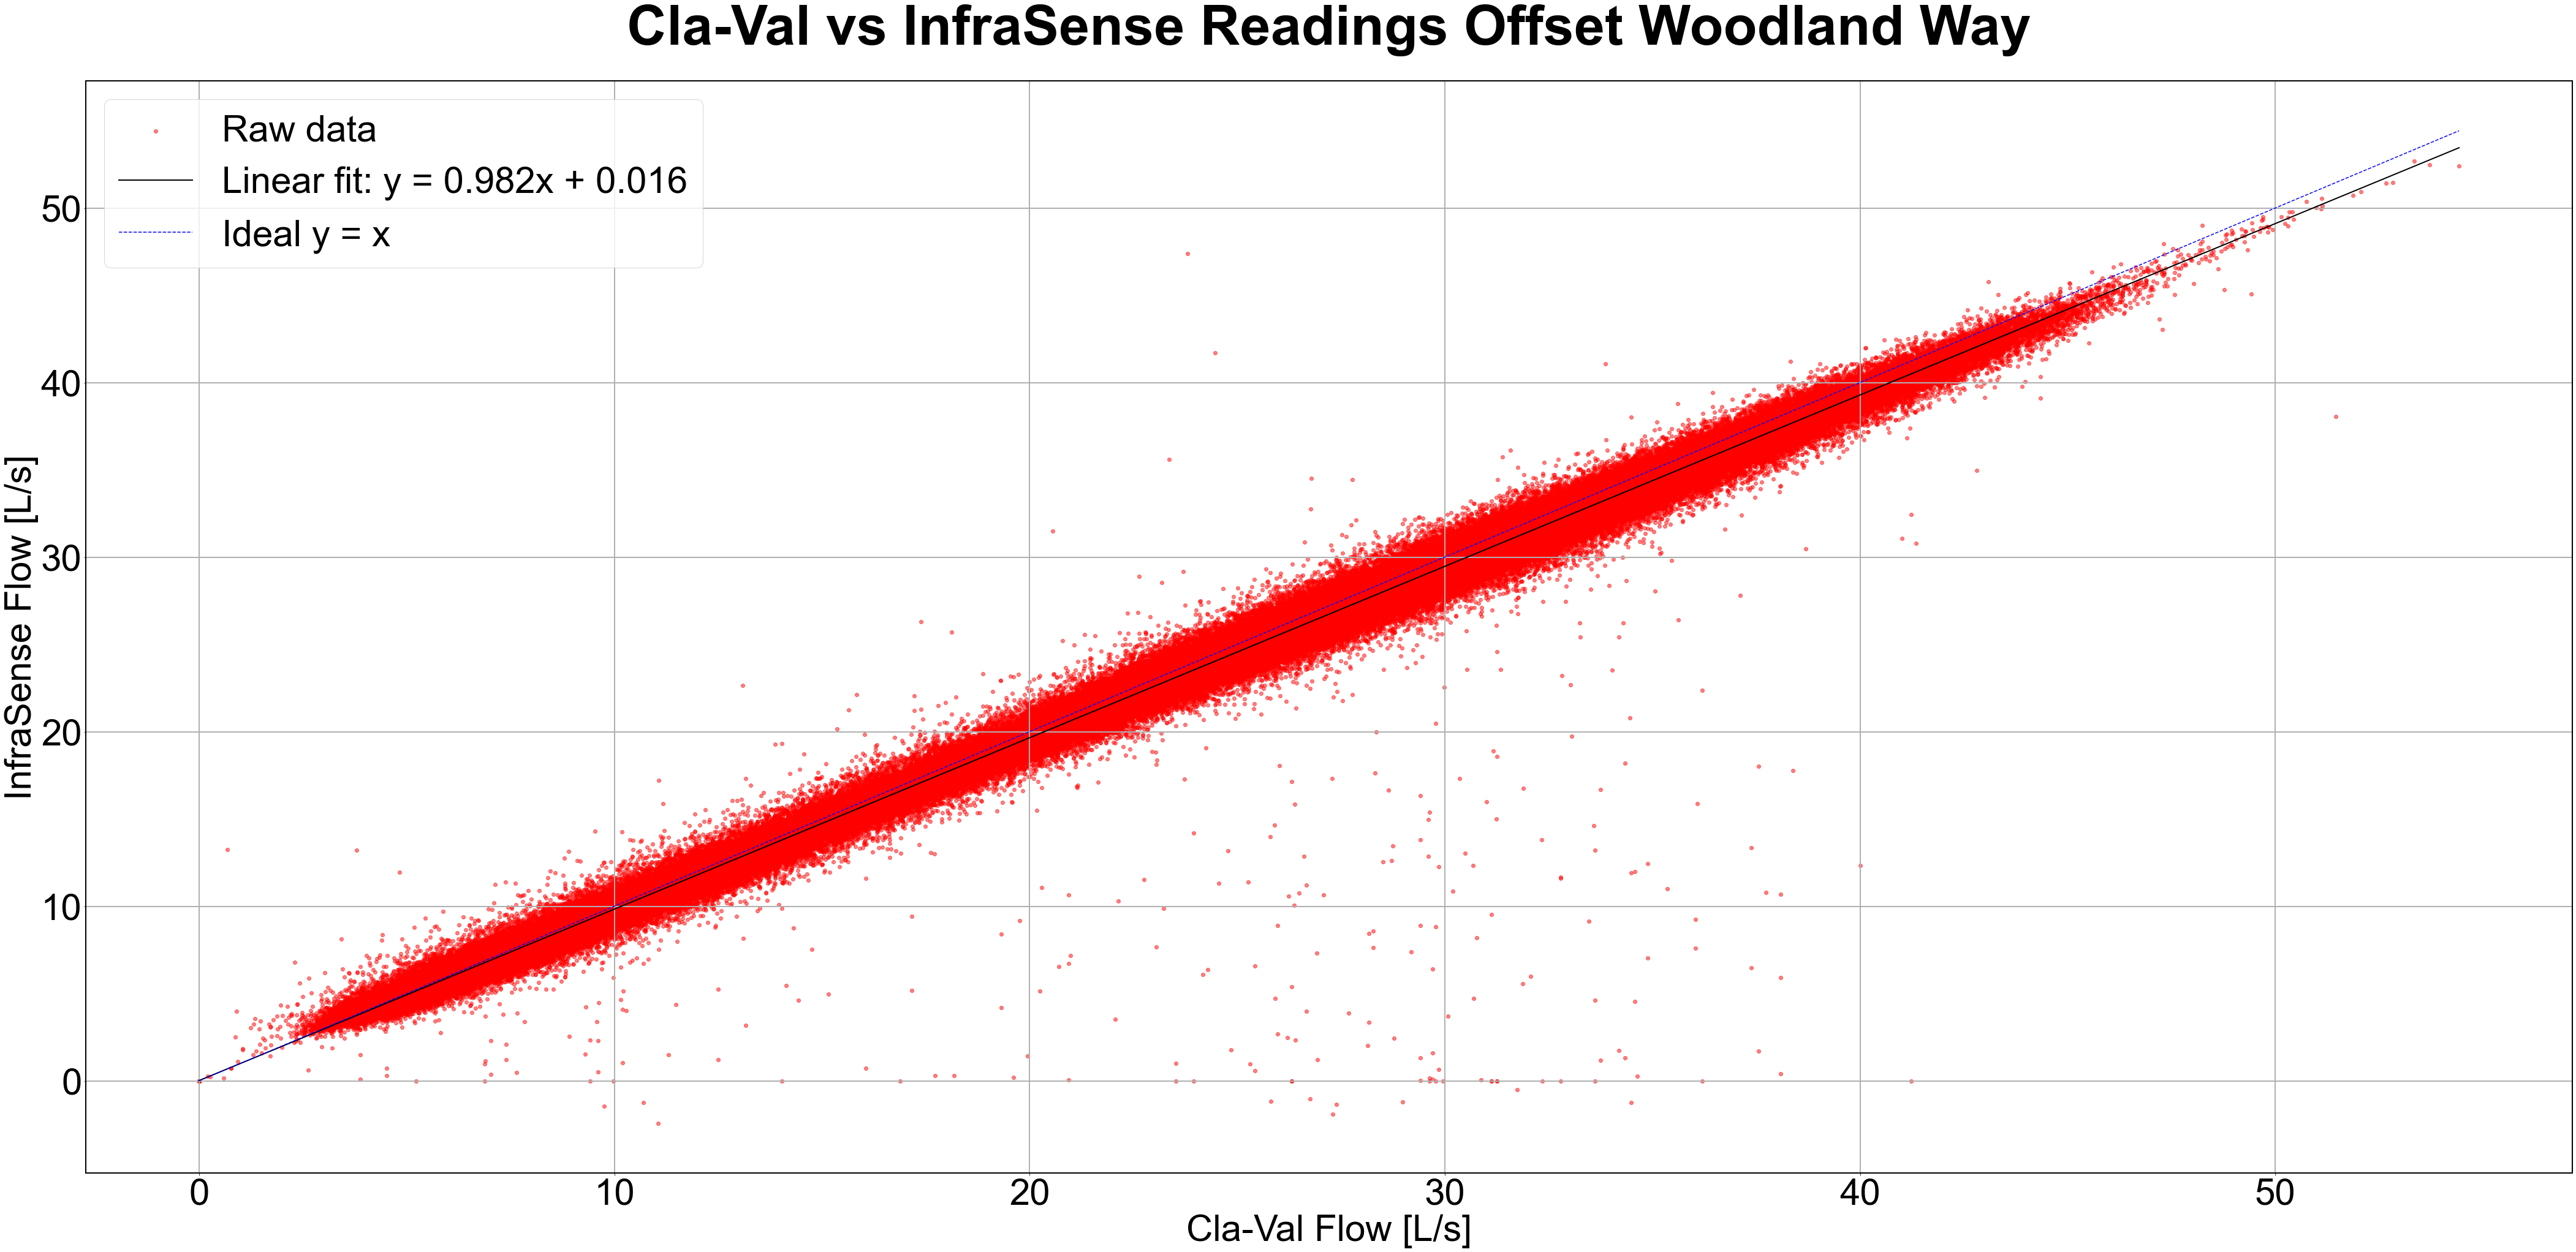

Average offset (InfraSense – ClaVal): 0.536 mH₂O
Median offset:                             0.436 mH₂O
Std dev of offset:                         0.554 mH₂O
Minimum offset:                            0.000 mH₂O
Maximum offset:                            41.264 mH₂O


In [29]:
start = '2024'
end   = '2025'

s_claval = (Flow_claval[Flow_str].loc[start:end].resample('1T').mean())
s_infras = (Flow_infras[Flow_str].loc[start:end].resample('1T').mean())

df = pd.DataFrame({'Claval': s_claval,'Infras': s_infras}).dropna()
slope, intercept, r_value, p_value, std_err = linregress(df['Claval'], df['Infras'])
x_vals = np.linspace(df['Claval'].min(), df['Claval'].max(), 200)
y_linreg = slope * x_vals + intercept


plt.figure()
plt.scatter(df['Claval'], df['Infras'], color='red', alpha=0.5, label='Raw data')
plt.plot(x_vals, y_linreg, color='black', lw=2, label=f'Linear fit: y = {slope:.3f}x + {intercept:.3f}')
plt.plot(x_vals, x_vals, linestyle='--', color='blue', lw=1.5, label='Ideal y = x')

plt.xlabel(r'Cla-Val Flow [L/s]')
plt.ylabel(r'InfraSense Flow [L/s]')
plt.title('Cla-Val vs InfraSense Readings Offset Woodland Way', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df['Offset'] = np.abs(df['Infras'] - df['Claval'])
avg_offset   = df['Offset'].mean()
med_offset   = df['Offset'].median()
std_offset   = df['Offset'].std()
min_offset   = df['Offset'].min()
max_offset   = df['Offset'].max()

print(f"Average offset (InfraSense – ClaVal): {avg_offset:.3f} mH₂O")
print(f"Median offset:                             {med_offset:.3f} mH₂O")
print(f"Std dev of offset:                         {std_offset:.3f} mH₂O")
print(f"Minimum offset:                            {min_offset:.3f} mH₂O")
print(f"Maximum offset:                            {max_offset:.3f} mH₂O")

The function and subsequent code block calculates the imputation error using the linear regression method.

In [30]:
def evaluate_imputation_error(claval_df: pd.DataFrame, infras_df: pd.DataFrame, target_str: str, holdout_start: pd.Timestamp,
    holdout_end: pd.Timestamp) -> dict:

    month_str = holdout_start.strftime("%Y-%m") 
    year, month = holdout_start.year, holdout_start.month
    start_of_month = pd.to_datetime(f"{month_str}-01 00:00")
    last_day = calendar.monthrange(year, month)[1]
    end_of_month   = pd.to_datetime(f"{month_str}-{last_day} 23:59")

    full_range = pd.date_range(start=start_of_month, end=end_of_month, freq="T")
    claval_full     = claval_df.reindex(full_range)
    infras_resamp   = infras_df.resample("1T").mean()
    infras_full     = infras_resamp.reindex(full_range)
    true_holdout = claval_full[target_str].loc[holdout_start:holdout_end]
    claval_train = claval_full.copy()
    claval_train.loc[holdout_start:holdout_end, target_str] = np.nan

    paired = pd.DataFrame({"claval": claval_train[target_str], "infras": infras_full[target_str]}).dropna()
    m, b = np.polyfit(paired["infras"], paired["claval"], 1)

    fill_series = m * infras_full[target_str] + b
    imputed = claval_train.copy()
    imputed[target_str] = imputed[target_str].fillna(fill_series)
    zero_idx = imputed[imputed[target_str] == 0].index
    imputed.loc[zero_idx, target_str] = infras_full.loc[zero_idx, target_str]
    imputed[target_str] = imputed[target_str].clip(lower=0)
    imputed_holdout = imputed[target_str].loc[holdout_start:holdout_end]
    
    diff = imputed_holdout - true_holdout
    rmse = np.sqrt(np.mean(diff ** 2))
    bias = np.mean(diff)

    nonzero_mask = true_holdout != 0
    if nonzero_mask.any():
        mape = np.mean(np.abs((imputed_holdout[nonzero_mask] - true_holdout[nonzero_mask]) /
                              true_holdout[nonzero_mask])) * 100
    else:
        mape = np.nan 

    return {"rmse": rmse,
        "bias": bias,
        "mape": mape,
        "holdout_start": holdout_start,
        "holdout_end": holdout_end,
        "m": m,
        "b": b}

In [31]:
month = '2024-04'

holdout_start = pd.Timestamp(f"{month}-08 00:00")
holdout_end   = pd.Timestamp(f"{month}-14 23:59")

print("=== Linear regression method ===")

# 1) P_in
claval_df     = P_in_claval[month]
infras_df     = P_in_infras[month]
target_str_in = Pin_str

results_P_in = evaluate_imputation_error(
    claval_df=claval_df,
    infras_df=infras_df,
    target_str=target_str_in,
    holdout_start=holdout_start,
    holdout_end=holdout_end
)
print("=== P_in Results ===")
print(f"RMSE: {results_P_in['rmse']:.3f}")
print(f"Bias: {results_P_in['bias']:.3f}")
print(f"MAPE: {results_P_in['mape']:.3f}%")
print(f"Slope (m): {results_P_in['m']:.4f}, Intercept (b): {results_P_in['b']:.4f}")
print()

# 2) P_out
claval_df      = P_out_claval[month]
infras_df      = P_out_infras[month]
target_str_out = Pout_str

results_P_out = evaluate_imputation_error(
    claval_df=claval_df,
    infras_df=infras_df,
    target_str=target_str_out,
    holdout_start=holdout_start,
    holdout_end=holdout_end
)
print("=== P_out Results ===")
print(f"RMSE: {results_P_out['rmse']:.3f}")
print(f"Bias: {results_P_out['bias']:.3f}")
print(f"MAPE: {results_P_out['mape']:.3f}%")
print(f"Slope (m): {results_P_out['m']:.4f}, Intercept (b): {results_P_out['b']:.4f}")
print()

# 3) Flow
claval_df       = Flow_claval[month]
infras_df       = Flow_infras[month]
target_str_flow = Flow_str

results_Flow = evaluate_imputation_error(
    claval_df=claval_df,
    infras_df=infras_df,
    target_str=target_str_flow,
    holdout_start=holdout_start,
    holdout_end=holdout_end
)
print("=== Flow Results ===")
print(f"RMSE: {results_Flow['rmse']:.3f}")
print(f"Bias: {results_Flow['bias']:.3f}")
print(f"MAPE: {results_Flow['mape']:.3f}%")
print(f"Slope (m): {results_Flow['m']:.4f}, Intercept (b): {results_Flow['b']:.4f}")

=== Linear regression method ===
=== P_in Results ===
RMSE: 0.163
Bias: -0.018
MAPE: 0.412%
Slope (m): 0.9536, Intercept (b): 1.4318

=== P_out Results ===
RMSE: 0.218
Bias: 0.083
MAPE: 0.992%
Slope (m): 0.9928, Intercept (b): -0.6173

=== Flow Results ===
RMSE: 0.424
Bias: -0.001
MAPE: 1.964%
Slope (m): 1.0156, Intercept (b): 0.0597


The function and code block below calculates the imputation error of offsetting the InfraSense by the monthly mean deviation and imputing into the Cla-Val dataset. 

In [32]:
def evaluate_imputation_error2( claval_df: pd.DataFrame, infras_df: pd.DataFrame, target_str: str, holdout_start: pd.Timestamp,
    holdout_end: pd.Timestamp) -> dict:


    month_str = holdout_start.strftime("%Y-%m")
    year, month = holdout_start.year, holdout_start.month
    start_of_month = pd.to_datetime(f"{month_str}-01 00:00")
    last_day = calendar.monthrange(year, month)[1]
    end_of_month   = pd.to_datetime(f"{month_str}-{last_day} 23:59")


    full_range = pd.date_range(start=start_of_month, end=end_of_month, freq="T")
    claval_full   = claval_df.reindex(full_range)
    infras_resamp = infras_df.resample("1T").mean()
    infras_full   = infras_resamp.reindex(full_range)

    true_holdout = claval_full[target_str].loc[holdout_start:holdout_end]
    claval_train = claval_full.copy()
    claval_train.loc[holdout_start:holdout_end, target_str] = np.nan

    paired = pd.DataFrame({ "claval": claval_train[target_str], "infras": infras_full[target_str]}).dropna()


    offset = np.mean(paired["claval"] - paired["infras"])

    fill_series = infras_full[target_str] + offset
    imputed = claval_train.copy()
    imputed[target_str] = imputed[target_str].fillna(fill_series)

    zero_idx = imputed[imputed[target_str] == 0].index
    imputed.loc[zero_idx, target_str] = infras_full.loc[zero_idx, target_str]
    imputed[target_str] = imputed[target_str].clip(lower=0)

    imputed_holdout = imputed[target_str].loc[holdout_start:holdout_end]

    diff = imputed_holdout - true_holdout
    rmse = np.sqrt(np.mean(diff ** 2))
    bias = np.mean(diff)
    
    nonzero_mask = true_holdout != 0
    if nonzero_mask.any():
        mape = np.mean(np.abs((imputed_holdout[nonzero_mask] - true_holdout[nonzero_mask]) / true_holdout[nonzero_mask])) * 100
    else:
        mape = np.nan

    return {
        "rmse": rmse,
        "bias": bias,
        "mape": mape,
        "holdout_start": holdout_start,
        "holdout_end": holdout_end,
        "offset": offset
    }

In [33]:
print("=== Mean offset method ===")

month = '2024-04'

holdout_start = pd.Timestamp(f"{month}-08 00:00")
holdout_end   = pd.Timestamp(f"{month}-14 23:59")




claval_df       = Flow_claval[month]
infras_df       = Flow_infras[month]
target_str_flow = Flow_str

results_Flow = evaluate_imputation_error2(
    claval_df=claval_df,
    infras_df=infras_df,
    target_str=target_str_flow,
    holdout_start=holdout_start,
    holdout_end=holdout_end
)
print("=== Flow Results ===")
print(f"RMSE: {results_Flow['rmse']:.3f}")
print(f"Bias: {results_Flow['bias']:.3f}")
print(f"MAPE: {results_Flow['mape']:.3f}%")


claval_df      = P_out_claval[month]
infras_df      = P_out_infras[month]
target_str_out = Pout_str

results_P_out = evaluate_imputation_error2(
    claval_df=claval_df,
    infras_df=infras_df,
    target_str=target_str_out,
    holdout_start=holdout_start,
    holdout_end=holdout_end
)
print("=== P_out Results ===")
print(f"RMSE: {results_P_out['rmse']:.3f}")
print(f"Bias: {results_P_out['bias']:.3f}")
print(f"MAPE: {results_P_out['mape']:.3f}%")
print()


claval_df     = P_in_claval[month]
infras_df     = P_in_infras[month]
target_str_in = Pin_str

results_P_in = evaluate_imputation_error2(
    claval_df=claval_df,
    infras_df=infras_df,
    target_str=target_str_in,
    holdout_start=holdout_start,
    holdout_end=holdout_end
)
print("=== P_in Results ===")
print(f"RMSE: {results_P_in['rmse']:.3f}")
print(f"Bias: {results_P_in['bias']:.3f}")
print(f"MAPE: {results_P_in['mape']:.3f}%")
print()

=== Mean offset method ===
=== Flow Results ===
RMSE: 0.453
Bias: 0.006
MAPE: 2.465%
=== P_out Results ===
RMSE: 0.218
Bias: 0.082
MAPE: 0.987%

=== P_in Results ===
RMSE: 0.187
Bias: 0.023
MAPE: 0.487%



The two functions below carry out the following operations:
1) Imputation of missing timestamps using the linear regression method.

2) Establish a complete timeseries dataset of target pressure based on flow and control curve values.

In [34]:
def major_imputation(claval_df: pd.DataFrame, infras_df: pd.DataFrame, target_str: str) -> pd.DataFrame:

    first_date = infras_df.index.min()
    month_str = first_date.strftime("%Y-%m")
    start_date = pd.to_datetime(f"{month_str}-01")
    year = first_date.year
    month = first_date.month
    last_day = calendar.monthrange(year, month)[1]
    end_date = pd.to_datetime(f"{month_str}-{last_day} 23:59")

    full_range = pd.date_range(start=start_date, end=end_date, freq='T')
    claval_full  = claval_df.reindex(full_range)
    infras_resamp = infras_df.resample('1T').mean()
    infras_full = infras_resamp.reindex(full_range)


    paired = pd.DataFrame({'claval': claval_full[target_str], 'infras': infras_full[target_str]}).dropna()
    m, b = np.polyfit(paired['infras'], paired['claval'], 1)
    fill_series = m * infras_full[target_str] + b

    imputed = claval_full.copy()
    imputed[target_str] = imputed[target_str].fillna(fill_series)

    zero_idx = imputed[imputed[target_str] == 0].index
    imputed.loc[zero_idx, target_str] = infras_full.loc[zero_idx, target_str]
    imputed[target_str] = imputed[target_str].clip(lower=0)

    return imputed

In [35]:
def major_imputation2(Ptarget_df: pd.DataFrame, Flow_df: pd.DataFrame) -> pd.DataFrame:

    first_date = Flow_df.index.min()
    month_str  = first_date.strftime("%Y-%m")
    start_date = pd.to_datetime(f"{month_str}-01")
    end_date   = Flow_df.index.max()
    full_range = pd.date_range(start=start_date, end=end_date, freq='T')
    claval_full = Ptarget_df.reindex(full_range)
    
    df_curve = (pd.DataFrame({"Flow":    Flow_df["flow"].reindex(full_range),
                              "P_target": Ptarget_df["pressure_target"].reindex(full_range)})
                .dropna().groupby("Flow", as_index=False)["P_target"].mean().sort_values("Flow")) 
    f_control = interp1d(df_curve["Flow"], df_curve["P_target"], kind="linear", fill_value="extrapolate")


    flow_vals = Flow_df["flow"].reindex(full_range).values
    fill_series = pd.Series(f_control(flow_vals), index=full_range)
    imputed = claval_full.copy()
    imputed["pressure_target"] = imputed["pressure_target"].fillna(fill_series)

    return imputed

The code below carries out the data imputation process on a monthly basis. Errornous readings in the Cla-Val dataset are also filtered out and imputed.

In [36]:
months = ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12',
          '2025-01', '2025-02', '2025-03', '2025-04']

Pin_Claval_dict = {}
Pout_Claval_dict = {}
Flow_Claval_dict = {}

for month in months:
    Pin_Claval_dict[month] = major_imputation(P_in_claval[month], P_in_infras[month], Pin_str)
    Pout_Claval_dict[month] = major_imputation(P_out_claval[month], P_out_infras[month], Pout_str)
    Flow_Claval_dict[month] = major_imputation(Flow_claval[month], Flow_infras[month], Flow_str)
    
Pin_imputed = pd.concat([Pin_Claval_dict[month][Pin_str] for month in months], axis=0).to_frame()
Pout_imputed = pd.concat([Pout_Claval_dict[month][Pout_str] for month in months], axis=0).to_frame()
Flow_imputed = pd.concat([Flow_Claval_dict[month][Flow_str] for month in months], axis=0).to_frame()

Pin_imputed[Pin_str] = Pin_imputed[Pin_str].interpolate(method='time')
Pout_imputed[Pout_str] = Pout_imputed[Pout_str].interpolate(method='time')
Flow_imputed[Flow_str] = Flow_imputed[Flow_str].interpolate(method='time')

t_bad = pd.to_datetime('2025-04-14 16:58:00')
Flow_imputed.at[t_bad, 'flow'] = np.nan
Flow_imputed['flow'] = Flow_imputed['flow'].interpolate(method='time')

t_bad = pd.to_datetime('2025-04-21 05:57:00')
Flow_imputed.at[t_bad, 'flow'] = np.nan
Flow_imputed['flow'] = Flow_imputed['flow'].interpolate(method='time')


start_date = '2024-01-01'
end_date   = Pin_imputed.index.max()
full_range = pd.date_range(start=start_date, end=end_date, freq='T')
Stem_claval = Stem_claval.reindex(full_range)
Stem_claval[Stem_str] = Stem_claval[Stem_str].clip(lower=0)
mask = (
    (Stem_claval.index >= pd.to_datetime('2025-03-31 00:00:00')) &
    (Stem_claval.index <= pd.to_datetime('2025-04-07 12:00:00'))
)
Stem_claval.loc[mask, Stem_str] = Stem_claval.loc[mask, Stem_str].fillna(0)
Stem_claval[Stem_str] = Stem_claval[Stem_str].interpolate(method='time')

The code below shows how the control curve can be obtained through flow and target pressure

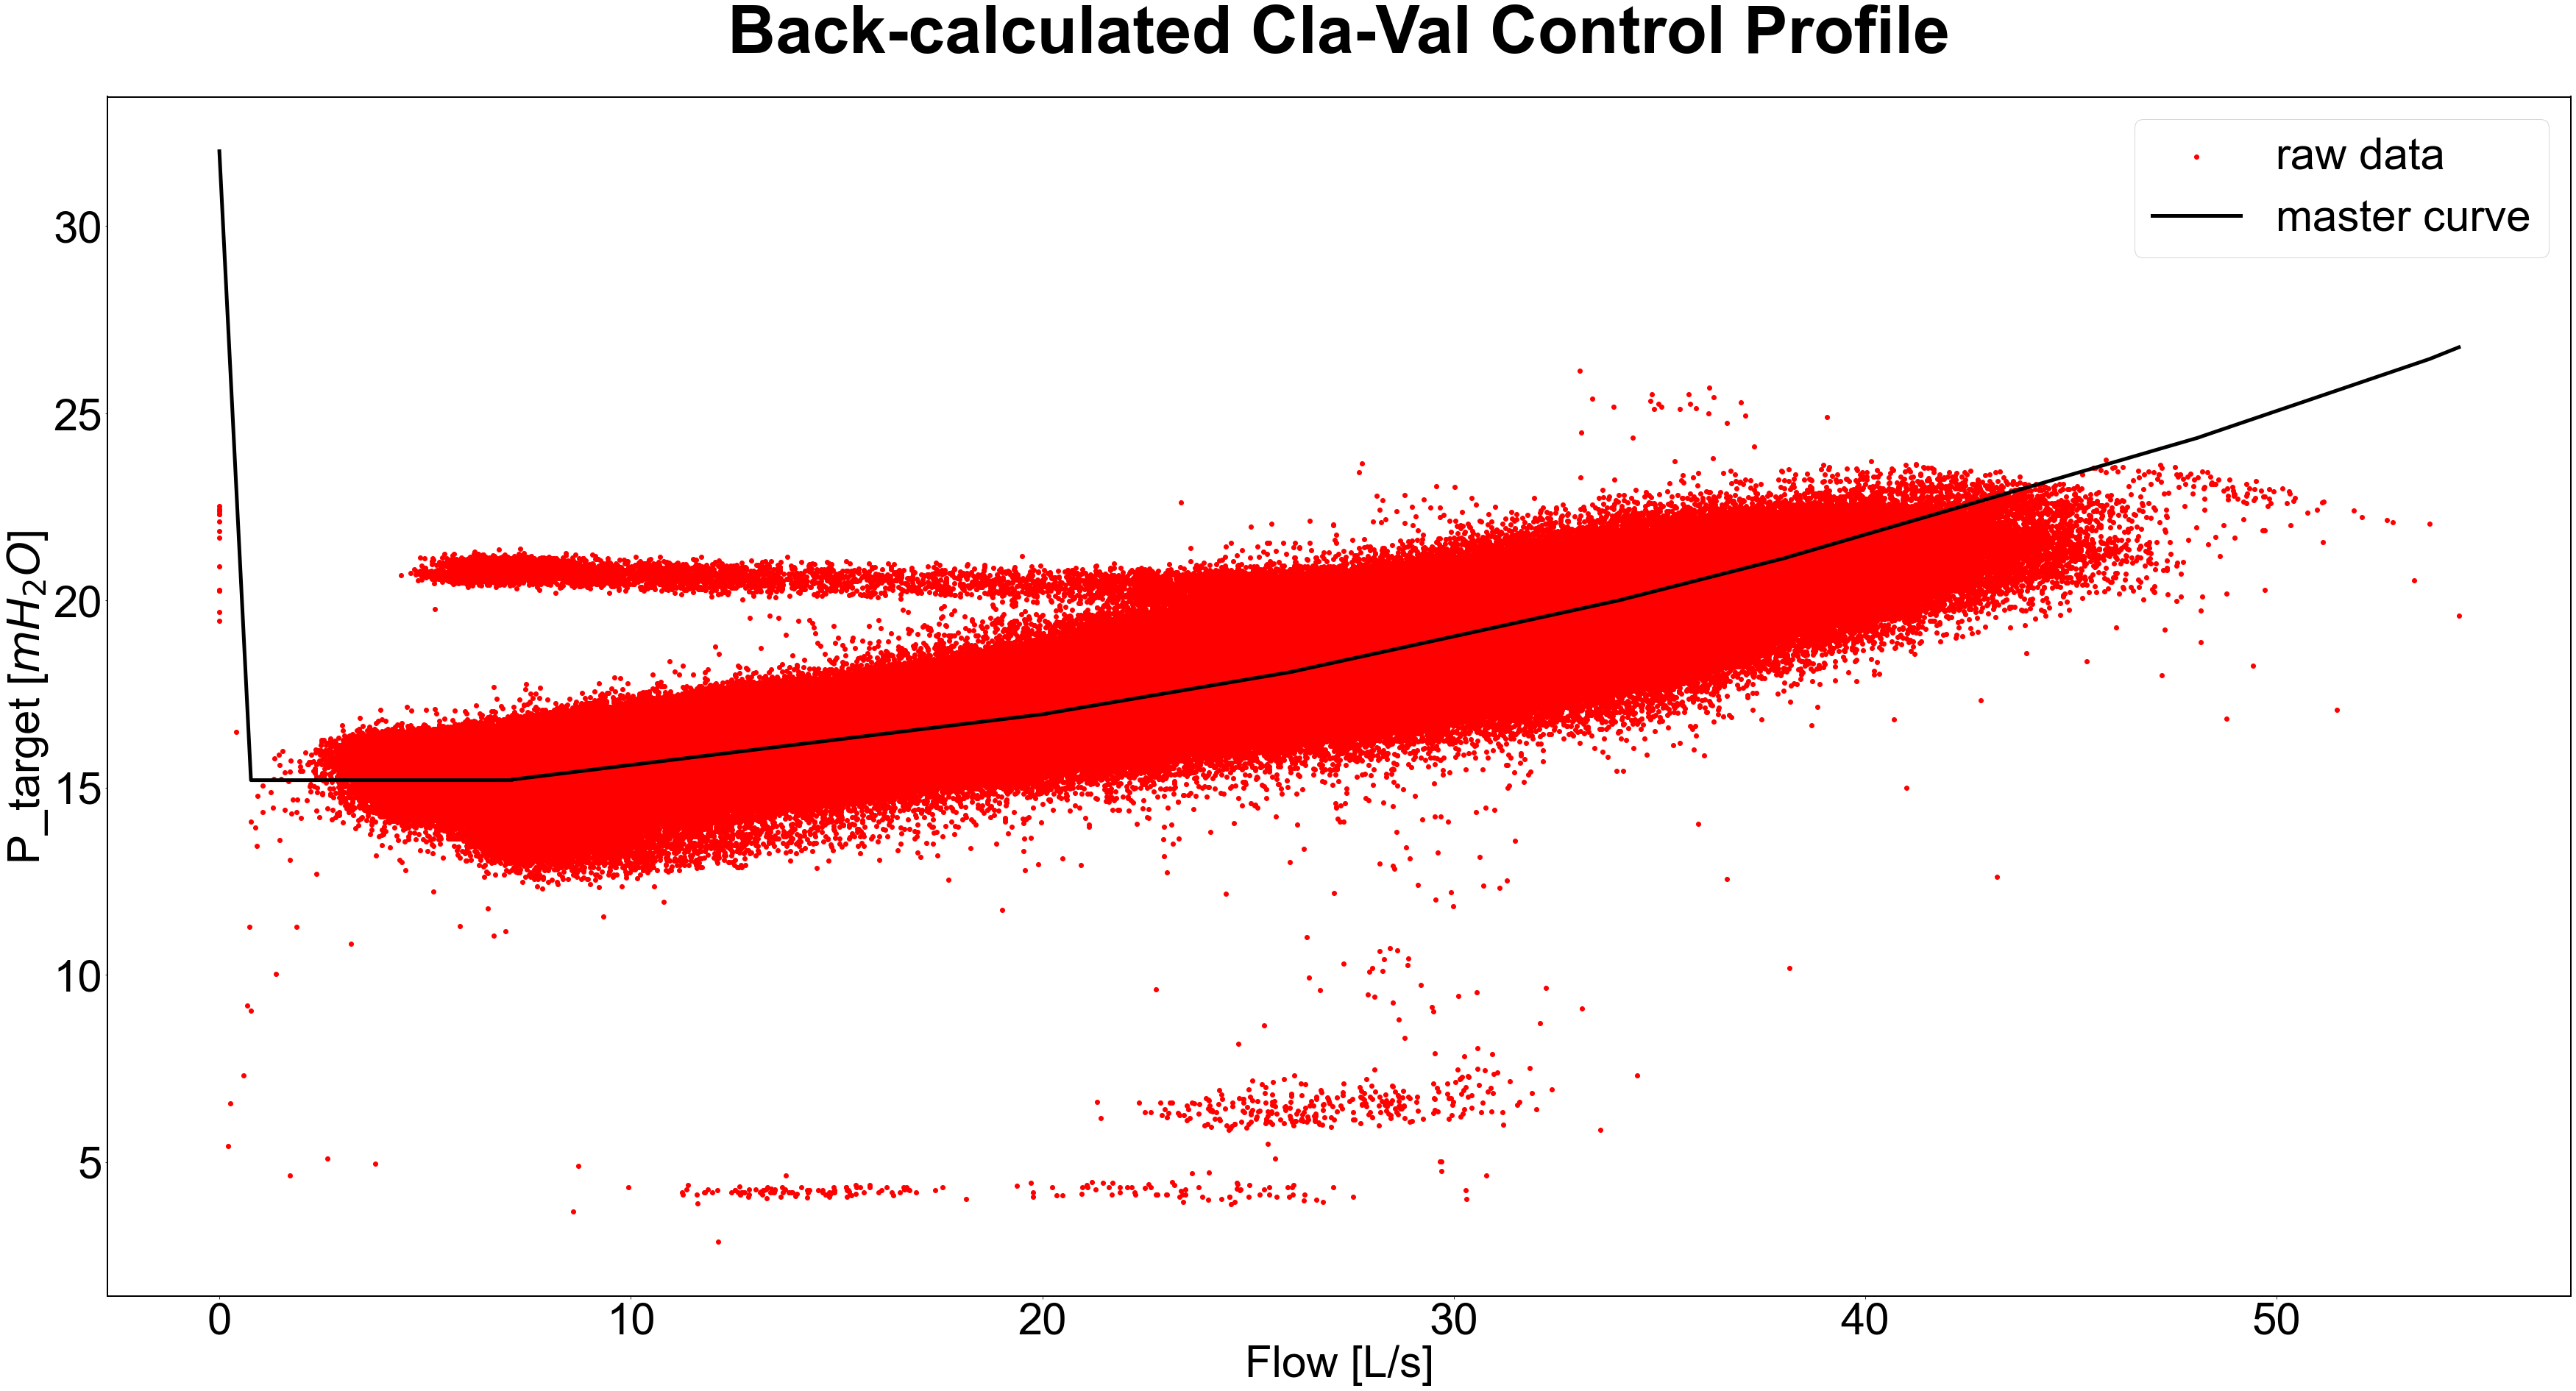

In [37]:
start = '2024-01'
end = '2025-02'

df = pd.DataFrame({'Flow':   Flow_claval[Flow_str][start:end],
                   'P_target': P_target[Ptarget_str][start:end]}).dropna()

group_field = 'Flow'
curve = (df.groupby(group_field, as_index=False)['P_target'].mean().sort_values(group_field).rename(columns={group_field: 'Flow'}))

f_control = interp1d(curve['Flow'], curve['P_target'], kind='linear', fill_value='extrapolate')

plt.figure()
plt.scatter(Flow_imputed[Flow_str], Pout_imputed[Pout_str], color= 'red', label='raw data')
plt.plot(curve['Flow'], curve['P_target'], color = 'black', lw=5, label='master curve')
plt.xlabel('Flow [L/s]')
plt.ylabel(r'P_target [$mH_2O$]')
plt.title('Back-calculated Cla-Val Control Profile', fontweight='bold')
plt.legend()
plt.show()

The full set of target pressure values are obtained using their respective control curves. Periods of fixed outlet pressure are also identified and imputed using the intended outlet pressure setpoint.

In [38]:
# CP1 for 01/01/2024 00:00:00 - 15/04/2025 00:08:00 is defined by the function f_control() 

# 15/04/2025 00:09:00 - 15/04/2025 11:50:00
CP2 = pd.DataFrame(data = {'abb' : [ 0,  0.3,    7, 20,   26, 30, 34,   38,   42,   45,   48,   51,   54, 57, 59, 62, 100],
                      'P_target' : [32, 15.2, 15.2, 17, 18.1, 19, 20, 21.1, 22.4, 23.4, 24.3, 25.4, 26.6, 28, 29, 32,  32]})

# 15/04/2025 11:51:00 - 16/04/2025 12:59:00
CP3 = pd.DataFrame(data = {'abb' : [ 0,  1,    5, 10,   15,   20,   25,   30,   35, 40,   45, 50, 55, 60, 62, 100],
                      'P_target' : [32, 14, 14.5, 15, 15.8, 16.5, 17.5, 18.5, 19.5, 21, 22.5, 24, 26, 29, 32, 32]})

# 16/04/2025 13:00:00 - 30/04/2025 23:59:00
CP4 = pd.DataFrame(data = {'abb' : [ 0,  1,  5, 10, 15, 20, 25, 30, 35,   40, 45, 50, 55, 100],
                      'P_target' : [32, 13, 13, 14, 15, 16, 17, 18, 19, 20.5, 22, 24, 32,  32]})

full_index = pd.date_range( start='2024-01-01 00:00:00', end='2025-04-30 23:59:00', freq='T')
full_index.name = P_target.index.name
P_reindexed = P_target.reindex(full_index)

abb = Flow_imputed[Flow_str].reindex(full_index).values
fill = pd.Series(index=full_index, dtype=float)

intervals = [
    (pd.to_datetime('2024-01-01 00:00:00'), pd.to_datetime('2025-04-15 00:08:00'), 'f_control'),
    (pd.to_datetime('2025-04-15 00:09:00'), pd.to_datetime('2025-04-15 11:50:00'), CP2),
    (pd.to_datetime('2025-04-15 11:51:00'), pd.to_datetime('2025-04-16 12:59:00'), CP3),
    (pd.to_datetime('2025-04-16 13:00:00'), pd.to_datetime('2025-04-30 23:59:00'), CP4)]

for start, end, cp in intervals:
    mask = (full_index >= start) & (full_index <= end)
    if isinstance(cp, str) and cp == 'f_control':
        flow_vals = abb[mask]
        fill_vals = f_control(flow_vals)
        fill.loc[mask] = fill_vals
    else:
        fill.loc[mask] = np.interp( abb[mask],  cp['abb'].values, cp['P_target'].values)

Ptarget_imputed = P_reindexed.copy()
missing = Ptarget_imputed[Ptarget_str].isna()
Ptarget_imputed.loc[missing, Ptarget_str] = fill.loc[missing]

s2024 = pd.to_datetime('2025-03-31 12:02:00')
e2024 = pd.to_datetime('2025-04-07 12:05:00')
mean_pout = Pout_imputed['pressure_out'].loc[s2024:e2024].mean()
mask2024  = (Ptarget_imputed.index >= s2024) & (Ptarget_imputed.index <= e2024)
Ptarget_imputed.loc[mask2024, Ptarget_str] = mean_pout

The following two code blocks define residual pressure and normalised residual pressure. Errornous values are removed and imputed.

In [39]:
Pres = pd.DataFrame({'residual_pressure': Pout_imputed['pressure_out'] - Ptarget_imputed['pressure_target']})

In [40]:
normalised = pd.DataFrame({'normalised_residual_pressure':Pres[Pres_str] / Flow_imputed[Flow_str]})
normalised.replace({ np.inf:  10,-np.inf: -10 },inplace=True)

Visualisations of the final complete datasets

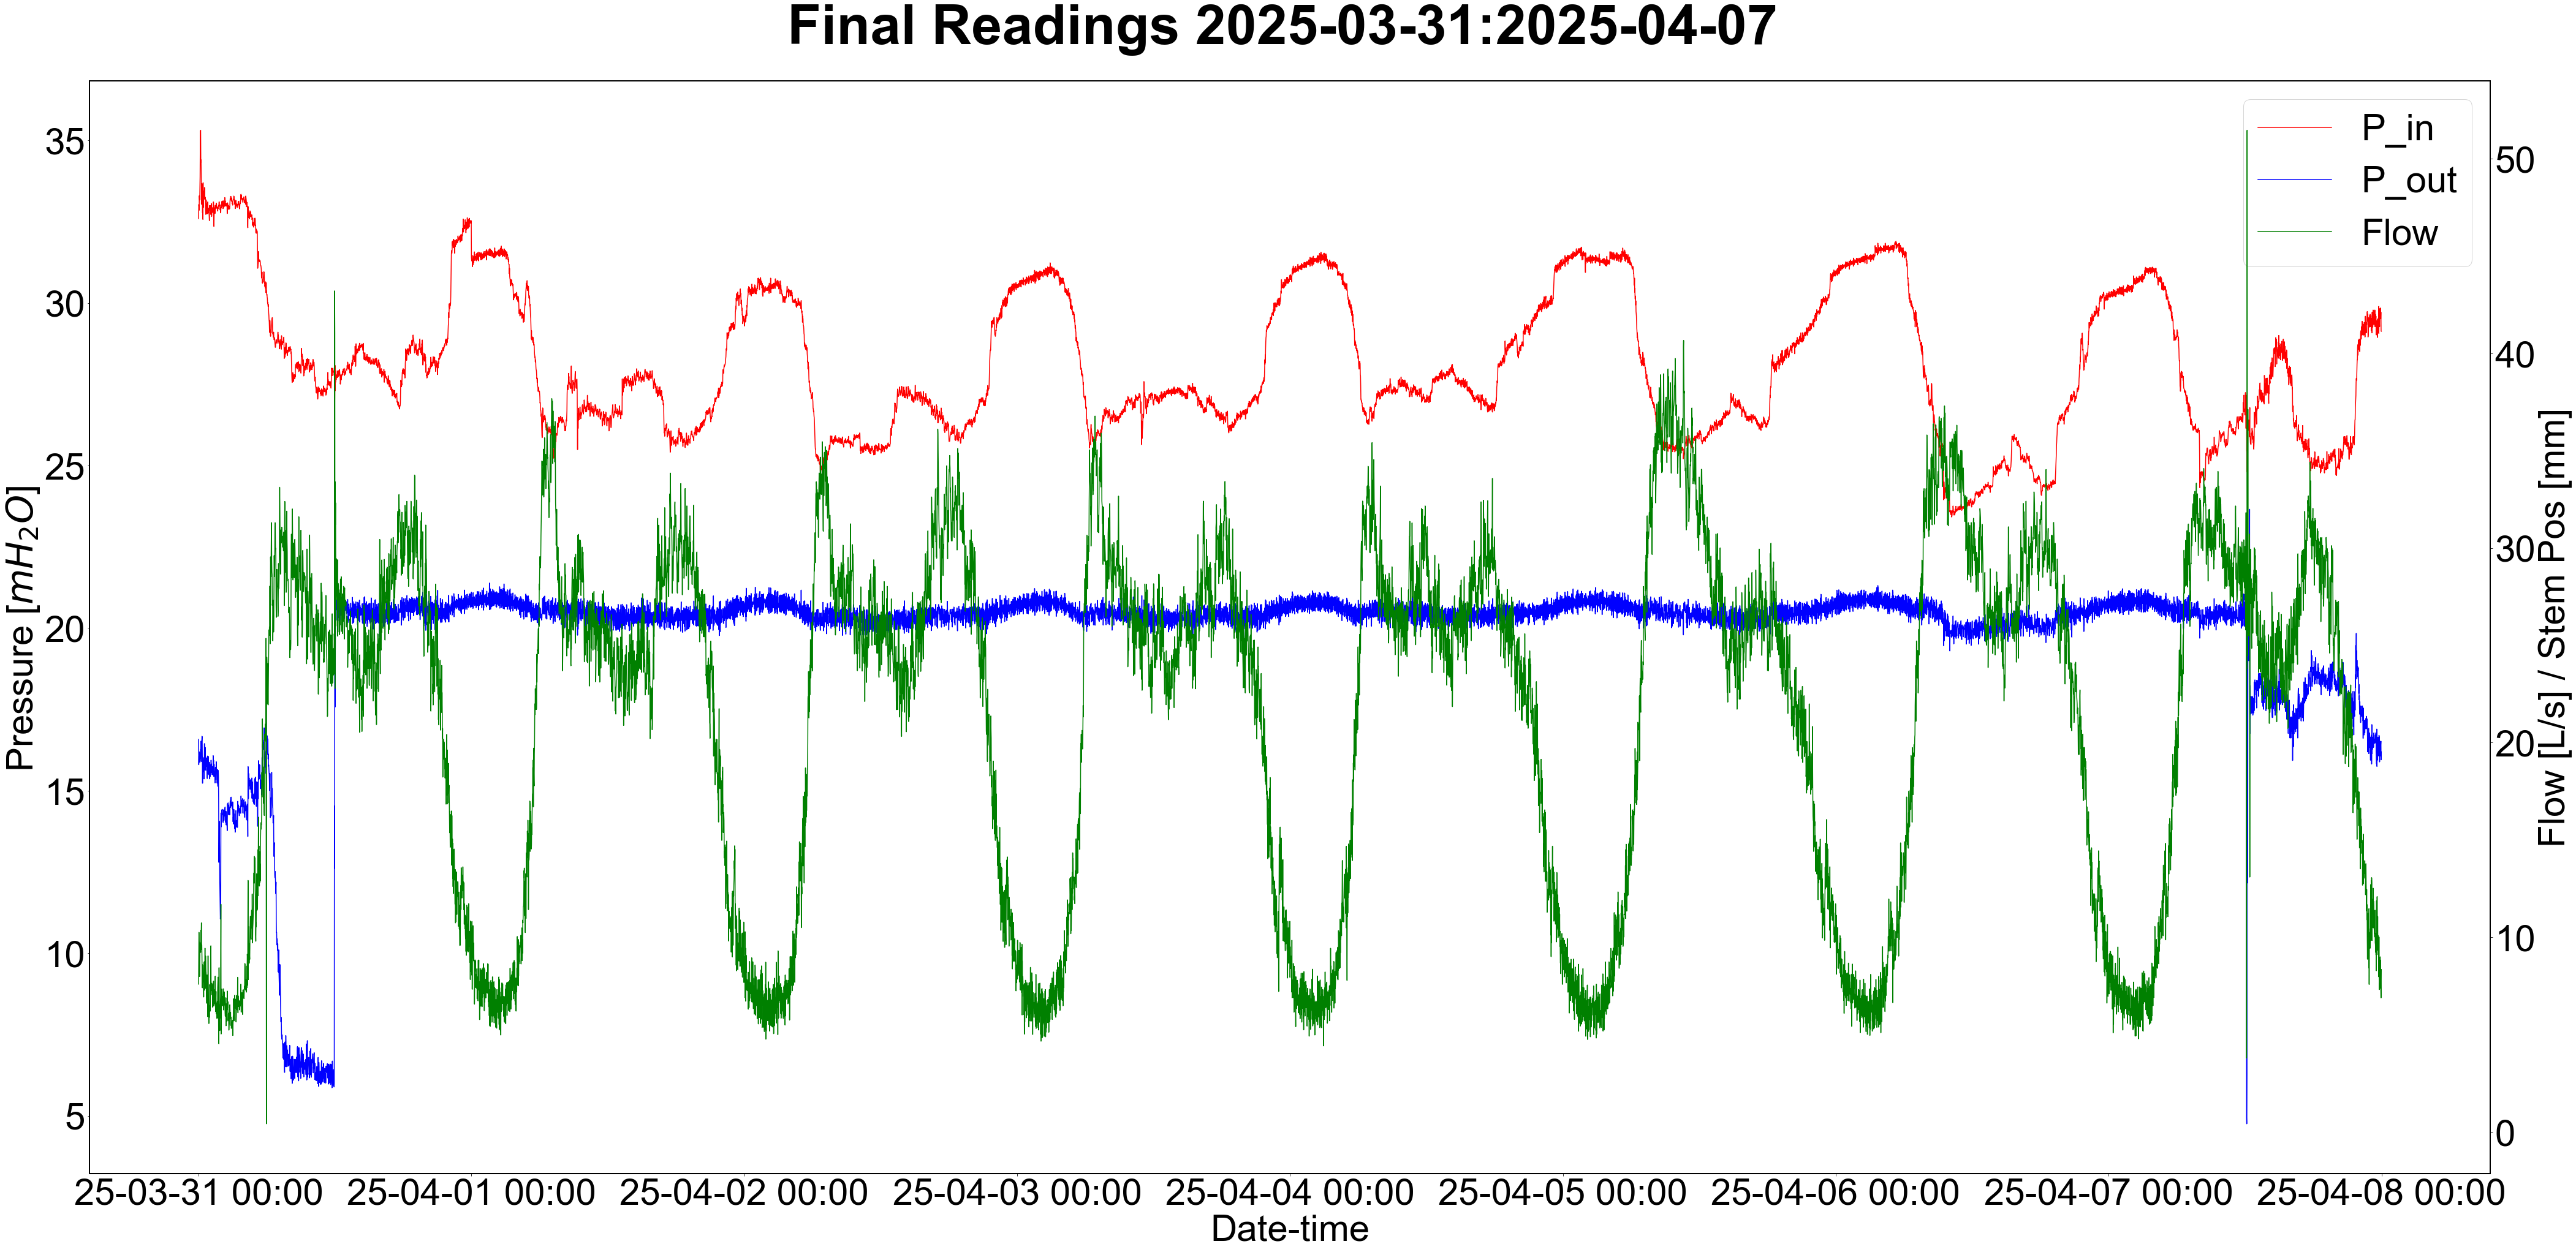

In [41]:
start = '2025-03-31'
end = '2025-04-07'

fig, ax1 = plt.subplots()

ax1.plot(Pin_imputed[start:end], label='P_in', color='red')
ax1.plot(Pout_imputed[start:end], label='P_out', color='blue')
#ax1.plot(Ptarget_imputed[start:end], label='P_target', color='cyan')

ax1.set_ylabel(r'Pressure [$mH_2O$] ')
ax1.set_xlabel('Date-time')

ax2 = ax1.twinx()
ax2.plot(Flow_imputed[start:end], label='Flow', color='green')
#ax2.plot(Stem_claval[start:end], label='Stem position', color='black')
ax2.set_ylabel('Flow [L/s] / Stem Pos [mm]') 


plt.title(f'Final Readings {start}:{end} ', fontweight='bold')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()

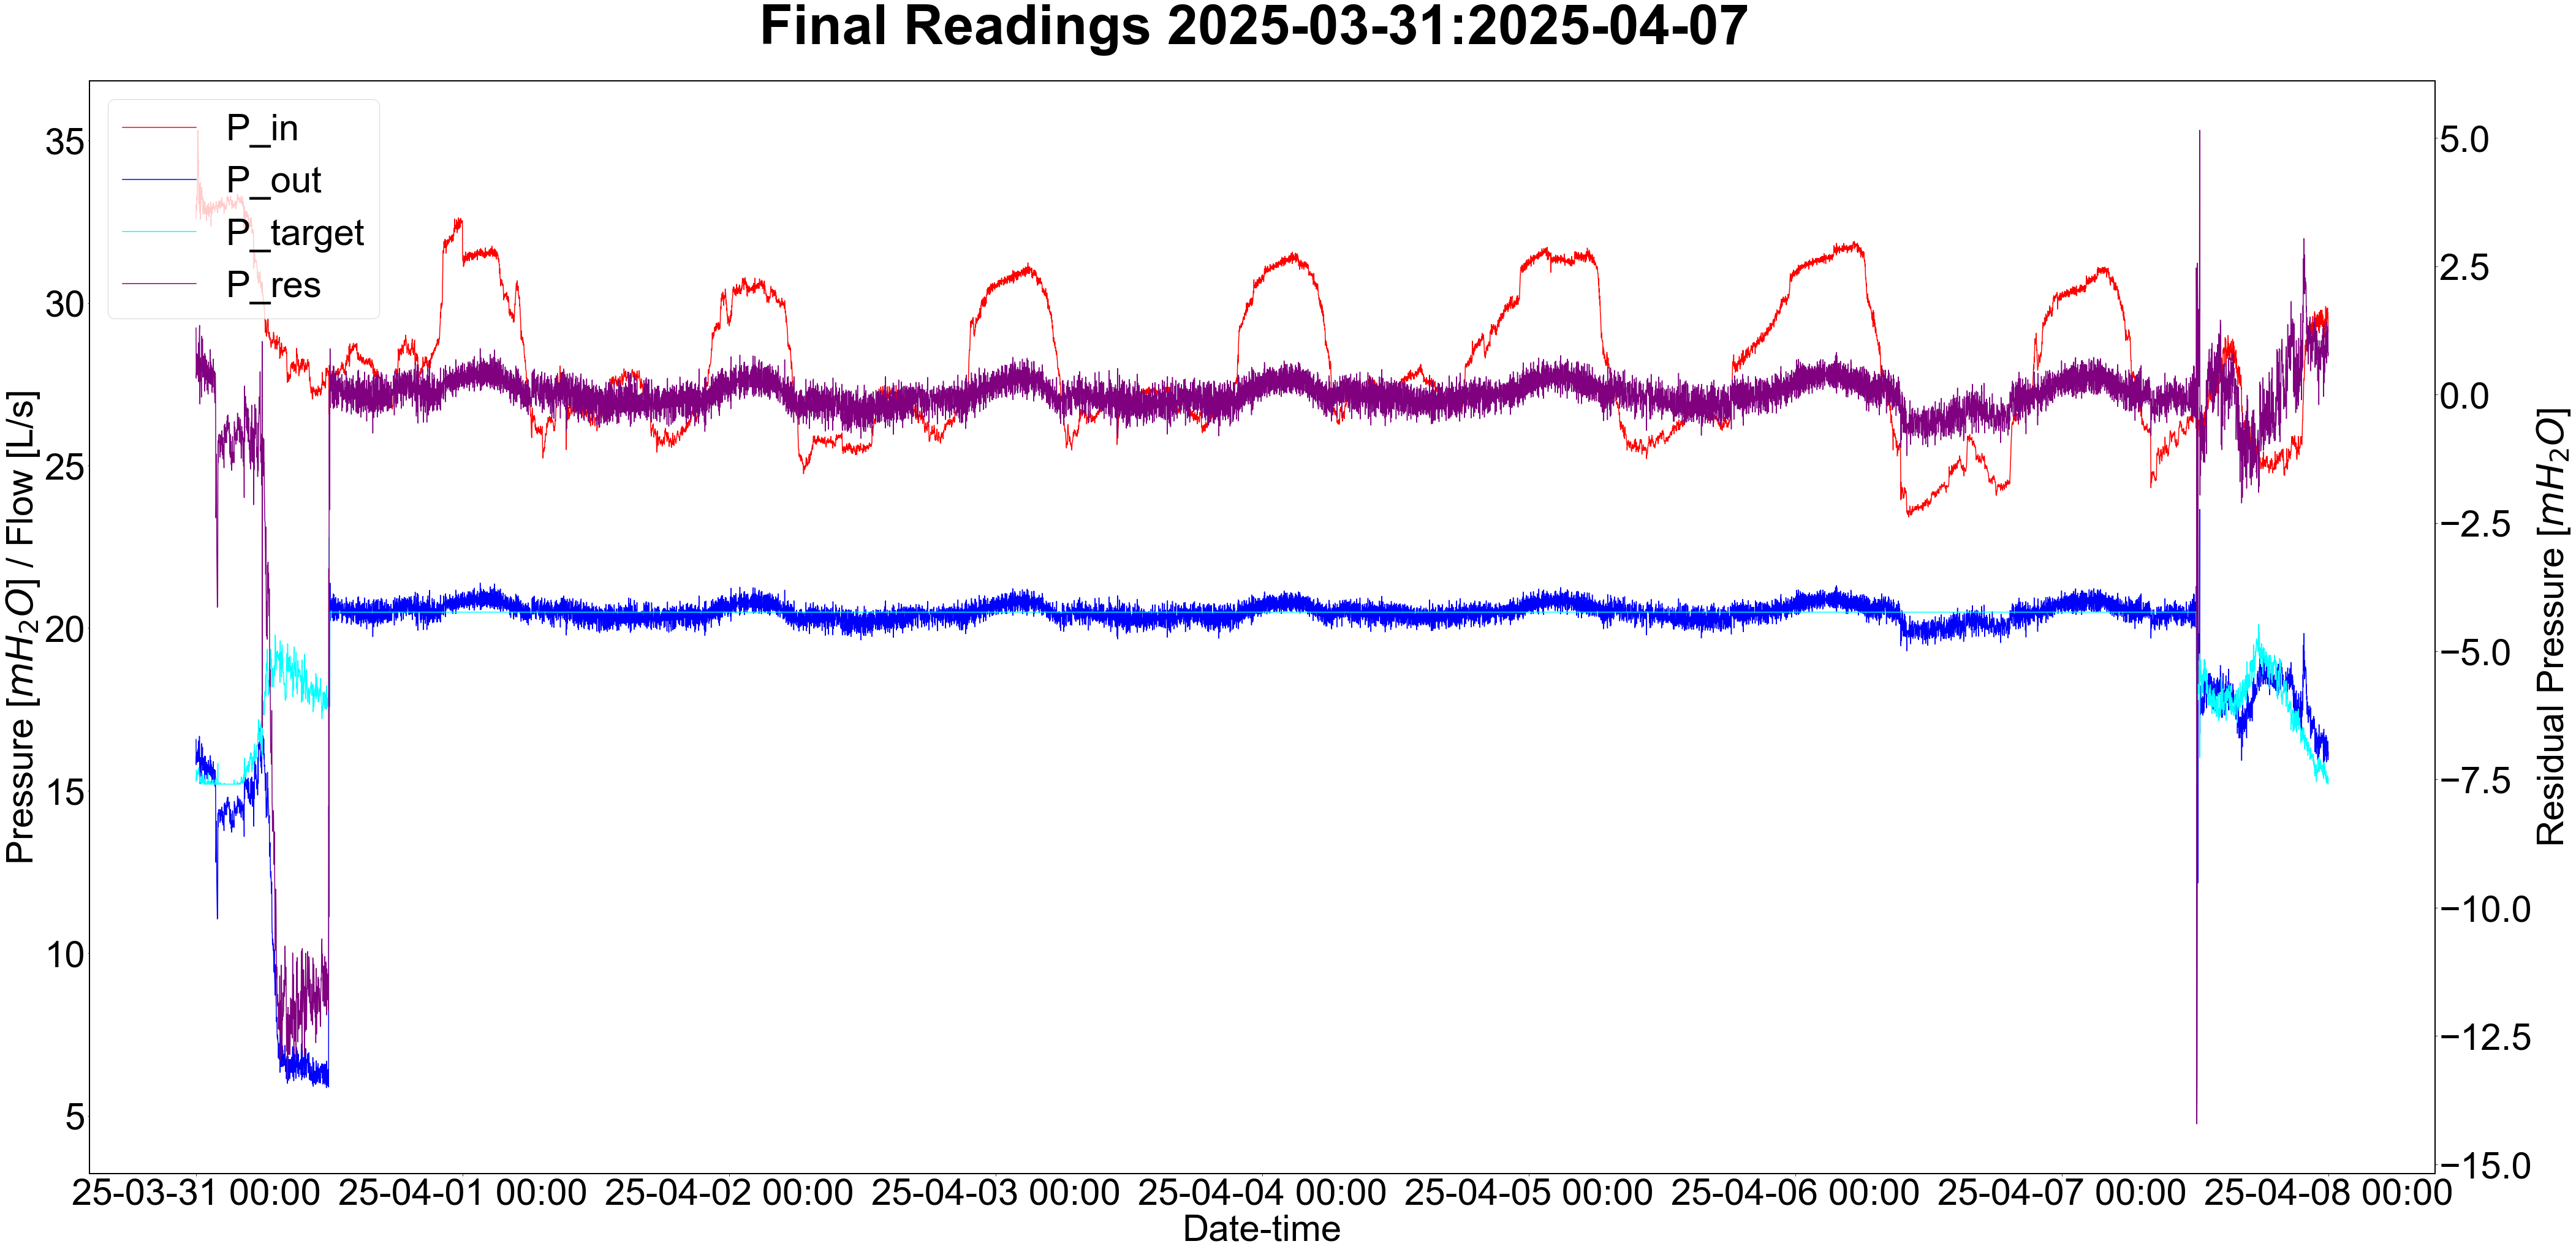

In [42]:
start = '2025-03-31'
end = '2025-04-07'

fig, ax1 = plt.subplots()
ax1.plot(Pin_imputed[start:end], label='P_in', color='red')
ax1.plot(Pout_imputed[start:end], label='P_out', color='blue')
ax1.plot(Ptarget_imputed[start:end], label='P_target', color='cyan')
#ax1.plot(Flow_imputed[start:end], label='Flow', color='green')

ax1.set_ylabel(r'Pressure [$mH_2O$] / Flow [L/s]')
ax1.set_xlabel('Date-time')

ax2 = ax1.twinx()
ax2.plot(Pres[start:end], label='P_res', color='purple')
ax2.set_ylabel('Residual Pressure [$mH_2O$]') 


plt.title(f'Final Readings {start}:{end} ', fontweight='bold')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()

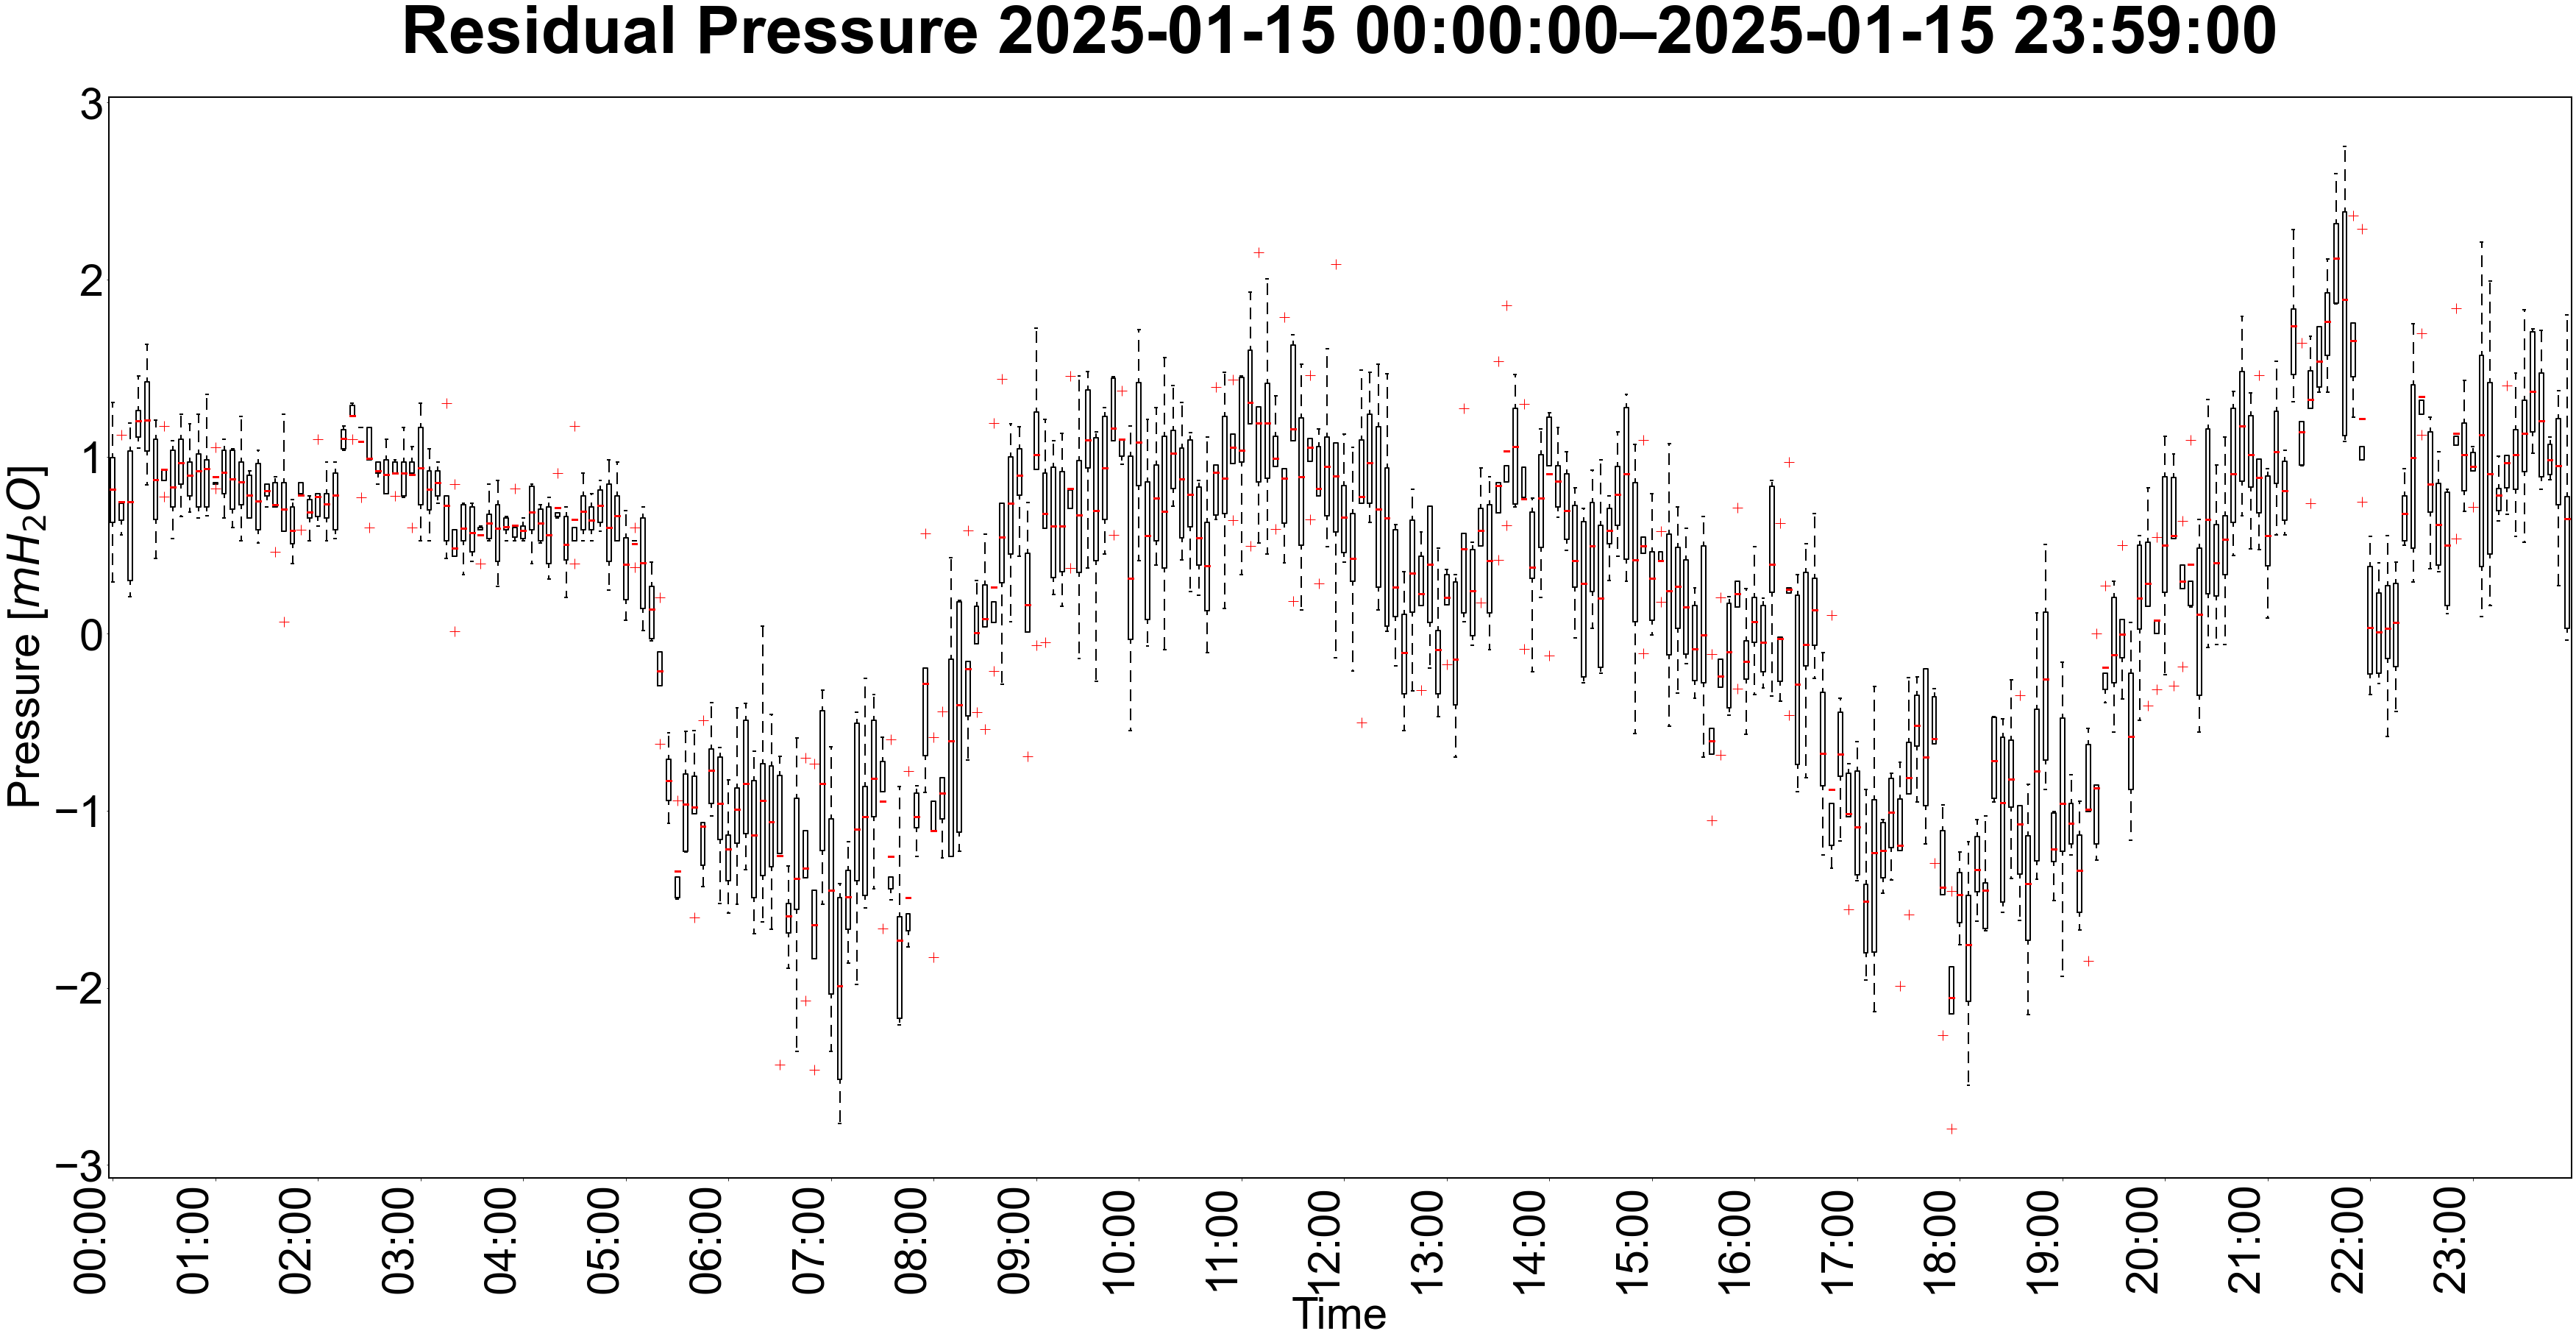

In [43]:
start, end = '2025-01-15 00:00:00', '2025-01-15 23:59:00'

Pout_M_boxdata = (
    Pres[Pres_str]
    .loc[start:end]
    .resample('5T')
    .apply(lambda s: s.values)
    .tolist()
)

fig, ax = plt.subplots()
boxplot = ax.boxplot(
    Pout_M_boxdata,
    showmeans=True,
    meanline=True,
    meanprops=dict(color="red", linewidth=3.0, linestyle='-'),
    medianprops=dict(color="white", linewidth=0),
    flierprops=dict(marker="+", markeredgecolor="red", markersize=14),
    whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=2.0),
    boxprops=dict(color='black', linewidth=2.0),
    capprops=dict(linewidth=2.0))
hourly = pd.date_range(start, end, freq='H')
tick_positions = np.arange(1, len(Pout_M_boxdata) + 1, 12)
tick_labels = [t.strftime('%H:%M') for t in hourly]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
fig.autofmt_xdate(rotation=90)
ax.set_xlabel('Time')
ax.set_ylabel(r'Pressure [$mH_2O$]')
ax.set_title(f'Residual Pressure {start}–{end}', fontweight='bold')

plt.show()

## 4. Windowing

The two code blocks below resample the datasets into fixed 5-minute windows and 10-minute windows with 50% overlaps. 

In [44]:
Pin_5T = Pin_imputed.resample('5T').mean()
Pout_5T = Pout_imputed.resample('5T').mean()
Flow_5T = Flow_imputed.resample('5T').mean()
Ptarget_5T = Ptarget_imputed.resample('5T').mean()
Pres_5T = Pres.resample('5T').mean()
normalsied_5T = normalised.resample('5T').mean()

In [45]:
window = '10T' 
step   = '5T'   


Pin_win1 = Pin_imputed.resample(window).mean()
Pout_win1 = Pout_imputed.resample(window).mean()
Flow_win1 = Flow_imputed.resample(window).mean()
Ptarget_win1 = Ptarget_imputed.resample(window).mean()
Pres_win1 = Pres.resample(window).mean()
normalised_win1 = normalised.resample(window).mean()

Pin_win2 = Pin_imputed.resample(window, offset=step).mean()
Pout_win2 = Pout_imputed.resample(window, offset=step).mean()
Flow_win2 = Flow_imputed.resample(window, offset=step).mean()
Ptarget_win2 = Ptarget_imputed.resample(window, offset=step).mean()
Pres_win2 = Pres.resample(window, offset=step).mean()
normalised_win2 = normalised.resample(window, offset=step).mean()

Pin_10ov = pd.concat([Pin_win1, Pin_win2]).sort_index()
Pout_10ov = pd.concat([Pout_win1, Pout_win2]).sort_index()
Flow_10ov = pd.concat([Flow_win1, Flow_win2]).sort_index()
Ptarget_10ov = pd.concat([Ptarget_win1, Ptarget_win2]).sort_index()
Pres_10ov = pd.concat([Pres_win1, Pres_win2]).sort_index()
normalised_10ov = pd.concat([normalised_win1, normalised_win2]).sort_index()

## 5. Export datasets

The following code blocks export the complete timeseries datasets with:
1) Original 1-minute sampling rate

2) Fixed 5-minute windows

3) 10-minute windows with 50% overlaps

In [46]:
#Pin_imputed.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pin_Final.csv", index=True)
#Pout_imputed.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pout_Final.csv", index=True)
#Flow_imputed.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Flow_Final.csv", index=True)
#Ptarget_imputed.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Ptarget_Final.csv", index=True)
#Pres.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pres_Final.csv", index=True)
#normalised.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Normalised_Final.csv", index=True)
#Stem_claval.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Stem_Final.csv", index=True)

In [47]:
# Pin_5T.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pin5T_Final.csv", index=True)
# Pout_5T.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pout5T_Final.csv", index=True)
# Flow_5T.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Flow5T_Final.csv", index=True)
# Ptarget_5T.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Ptarget5T_Final.csv", index=True)
# Pres_5T.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pres5T_Final.csv", index=True)
# normalsied_5T.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Normalised5T_Final.csv", index=True)

In [48]:
# Pin_10ov.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pin10ov_Final.csv", index=True)
# Pout_10ov.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pout10ov_Final.csv", index=True)
# Flow_10ov.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Flow10ov_Final.csv", index=True)
# Ptarget_10ov.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Ptarget10ov_Final.csv", index=True)
# Pres_10ov.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Pres10ov_Final.csv", index=True)
# normalised_10ov.to_csv("C:/Users/megat/Desktop/MegatAiman/University/Year4/FYP/Data/WoodlandWay/ProcessedData/Normalised10ov_Final.csv", index=True)